In [1]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from PIL import Image
import albumentations as A

from scipy.io import loadmat
import matplotlib.pyplot as plt

# from numpngw import write_png

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
### source :
src_image_path = '/content/drive/MyDrive/Colab Notebooks/suadd/inputs/'
src_mask_path = '/content/drive/MyDrive/Colab Notebooks/suadd/semantic_annotations/'

### destination
image_corrected_path = '/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/'
mask_corrected_path  = '/content/drive/MyDrive/Colab Notebooks/suadd/semantic_annotations_corrected/'

In [5]:
image_corrected_path, mask_corrected_path

('/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/',
 '/content/drive/MyDrive/Colab Notebooks/suadd/semantic_annotations_corrected/')

## AUGMENTATIONS:


# Augmentation mosaic version 1

In [ ]:
def mosaic_combine(loc, center_position_xy, img_shape_wh):
    """Calculate global coordinate of mosaic image and local coordinate of
    cropped sub-image.

    Args:
        loc (str): Index for the sub-image, loc in ('top_left',
          'top_right', 'bottom_left', 'bottom_right').
        center_position_xy (Sequence[float]): Mixing center for 4 images,
            (x, y).
        img_shape_wh (Sequence[int]): Width and height of sub-image

    Returns:
        tuple[tuple[float]]: Corresponding coordinate of pasting and
            cropping
            - paste_coord (tuple): paste corner coordinate in mosaic image.
            - crop_coord (tuple): crop corner coordinate in mosaic image.
    """

    assert loc in ('top_left', 'top_right', 'bottom_left', 'bottom_right')
    if loc == 'top_left':
        # index0 to top left part of image
        x1, y1, x2, y2 = 0, \
                         0, \
                         center_position_xy[0], \
                         center_position_xy[1]
        
        crop_coord = img_shape_wh[0] - (x2 - x1), img_shape_wh[1] - (y2 - y1), img_shape_wh[0], img_shape_wh[1]

    elif loc == 'top_right':
        # index1 to top right part of image
        x1, y1, x2, y2 = center_position_xy[0],\
                         0, \
                         img_shape_wh[0], \
                         center_position_xy[1]
        
        crop_coord = 0, img_shape_wh[1] - (y2 - y1), min(img_shape_wh[0], x2 - x1), img_shape_wh[1]

    elif loc == 'bottom_left':
        # index2 to bottom left part of image
        x1, y1, x2, y2 = 0, \
                         center_position_xy[1], \
                         center_position_xy[0], \
                         img_shape_wh[1]
        
        crop_coord = img_shape_wh[0] - (x2 - x1), 0, img_shape_wh[0], min(y2 - y1, img_shape_wh[1])

    else:
        # index3 to bottom right part of image
        x1, y1, x2, y2 = center_position_xy[0], \
                         center_position_xy[1], \
                        img_shape_wh[0] , \
                         img_shape_wh[1] 
#                          min(center_position_xy[0] + img_shape_wh[0], img_scale[1]), \
#                          min(img_scale[0], center_position_xy[1] + img_shape_wh[1])
        
        crop_coord = 0, 0, min(img_shape_wh[0], x2 - x1), min(y2 - y1, img_shape_wh[1])

    paste_coord = x1, y1, x2, y2
    return paste_coord, crop_coord

In [ ]:

img_scale=(2200, 1550)
center_ratio_range=(0.3, .7)
pad_val=0
seg_pad_val=255
img_shape_wh = img_scale

In [ ]:
position = ['top_left', 'top_right', 'bottom_left', 'bottom_right']

mosaic_combine(position[2], (2200,0), img_shape_wh)

In [ ]:
#center position 

def produce_aug_img(train_images, img_scale=(2200, 1550), center_ratio_range=(0.3, .7)):
    
    img_shape_wh = img_scale

    center_x = int(np.random.uniform(center_ratio_range[0], center_ratio_range[1]) * img_scale[1])
    center_y = int(np.random.uniform(center_ratio_range[0], center_ratio_range[1]) * img_scale[0])
    center_position = (center_x, center_y)
    center_position
#     print(center_position)

    # 1st image:
    train_len = len(train_images)

    images_path_exclude = []

    path_idx_list = []

    for a in position:

        train_possibles = [ x for x in train_images if x not in images_path_exclude]
        path_picked = int(np.random.uniform(0, len(train_possibles)))
        path_idx = train_possibles[path_picked]
        images_path_exclude.extend([x for x in train_possibles if path_idx.split('-')[0] in x])
        path_idx_list.append(path_idx)


    img_final = np.zeros((img_scale))
    mask_final = np.zeros((img_scale))
    depth_final = np.zeros((img_scale))



    for i,pos in enumerate(['top_left', 'top_right', 'bottom_left', 'bottom_right']):

        
        paste_coord, crop_coord = mosaic_combine(position[i], center_position, img_shape_wh[::-1])


        
        msk_path = './semantic_annotations/' + path_idx_list[i].split('/')[-1]
        dep_path = './depth_annotations/' + path_idx_list[i].split('/')[-1]
        
        
        img_pos = Image.open(path_idx_list[i])
        img_pos = np.array(img_pos.resize(img_scale[::-1]))
        
#         print(msk_path)
        msk_pos = Image.open(msk_path)
        msk_pos = np.array(msk_pos.resize(img_scale[::-1], Image.NEAREST))
        
        dep_pos = cv2.imread(dep_path, cv2.IMREAD_UNCHANGED)
        dep_pos = cv2.resize(dep_pos, img_scale[::-1] , interpolation = cv2.INTER_NEAREST)



        x1, y1, x2, y2 = crop_coord
        img_pos_tmp = img_pos[  y1:y2, x1:x2, ].copy()
        msk_pos_tmp = msk_pos[  y1:y2, x1:x2, ].copy()
        dep_pos_tmp = dep_pos[  y1:y2, x1:x2, ].copy()
        


        x1, y1, x2, y2 = paste_coord
        img_final[ y1:y2, x1:x2,] = img_pos_tmp
        mask_final[ y1:y2, x1:x2,] = msk_pos_tmp
        depth_final[ y1:y2, x1:x2,] = dep_pos_tmp
        
        
    return img_final, mask_final, depth_final




img_final, mask_final, depth_final= produce_aug_img(train_images)



print(np.unique(mask_final), (mask_final==255).sum()/(2200*1500)*100)
print((depth_final==0).sum()/(2200*1500)*100)

plt.figure(figsize=(20,20))

plt.subplot(1,4,1)
plt.imshow(img_final)
plt.subplot(1,4,2)
plt.imshow(mask_final)
plt.subplot(1,4,3)
plt.imshow(depth_final)

In [ ]:
from numpngw import write_png

save_img_path = '/data_ssd2/temp_xav/suadd2023/inputs/'
save_msk_path = '/data_ssd2/temp_xav/suadd2023/semantic_annotations/'
save_dep_path = '/data_ssd2/temp_xav/suadd2023/depth_annotations/'


for i in range(3000):
    
    img_final, mask_final, depth_final= produce_aug_img(train_images)
    
    img = Image.fromarray(img_final)
    img = img.convert("L")
    img.save(save_img_path+'aug_img'+'_v00212'+'__'+str(i)+'.png')
    
    img = Image.fromarray(mask_final)
    img = img.convert("L")
    img.save(save_msk_path+'aug_img'+'_v00212'+'__'+str(i)+'.png')
    
    img = depth_final.astype(np.uint16)
    write_png(save_dep_path+'aug_img'+'_v00212'+'__'+str(i)+'.png', img)

    
    if i%500 == 0:
        print(i)

In [ ]:
## Augmentation mosaic version 2

# Augmentation mosaic version 2

In [ ]:
# !cp -r '/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/' ./

In [ ]:
# !cp -r '/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/' ./

In [ ]:
train_images = glob(image_corrected_path+'*')
len(train_images)

4127

In [ ]:
%%timeit -n 10
for i in range(3):
  cv2.imread(train_images[i])

135 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n 10
for i in range(3):
  Image.open(train_images[i])

3.34 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
train_images = [x for x in train_images if 'aug__' not in x]
len(train_images)

4127

In [ ]:

img_scale=(2200, 1550)
center_ratio_range=(0.3, .7)
pad_val=0
seg_pad_val=255
img_shape_wh = img_scale

In [ ]:
def random_crop(img, mask, width, height):
  assert img.shape[0] >= height
  assert img.shape[1] >= width
#     assert img.shape[0] == mask.shape[0]
#     assert img.shape[1] == mask.shape[1]
  x = random.randint(0, img.shape[1] - width)
  y = random.randint(0, img.shape[0] - height)
  img = img[y:y+height, x:x+width]
  mask = mask[y:y+height, x:x+width]
  return img, mask

In [ ]:
import random

def produce_aug_img_2(train_images, img_scale=(2198, 1570), center_ratio_range=(0.3, .7)):
    
  img_shape_wh = img_scale


  # 1st image:
  train_len = len(train_images)

  images_path_exclude = []

  path_idx_list = []
  
  position = [(0,0),      (0,314),      (0,628),      (0,942),    (0,1256), (0, 1570), (0, 1884),
              (314,0),    (314,314),    (314,628),    (314,942),  (314,1256), (314, 1570), (314, 1884),
              (628,0),    (628,314),    (628,628),    (628,942),  (628,1256), (628, 1570), (628, 1884),
              (942,0),    (942,314),    (942,628),    (942,942),  (942,1256), (942, 1570), (942, 1884),
              (1256,0),    (1256,314),    (1256,628),    (1256,942),  (1256,1256), (1256, 1570), (1256, 1884),
              ]

  for a in position:

    train_possibles = [ x for x in train_images if x not in images_path_exclude]
    path_picked = int(np.random.uniform(0, len(train_possibles)))
    path_idx = train_possibles[path_picked]
    images_path_exclude.extend([x for x in train_possibles if path_idx.split('-')[0] in x])
    path_idx_list.append(path_idx)


  img_final = np.zeros((img_scale))
  mask_final = np.zeros((img_scale))

  for i,pos in enumerate(position):
   
    msk_path = mask_corrected_path + path_idx_list[i].split('/')[-1]
    # dep_path = './depth_annotations/' + path_idx_list[i].split('/')[-1]

    img_pos = Image.open(path_idx_list[i])
    img_pos = np.array(img_pos)
    
    msk_pos = Image.open(msk_path)
    msk_pos = np.array(msk_pos)

    x1, y1, x2, y2 = pos[0], pos[1], pos[0]+314, pos[1]+314
    # print(y1, y2, x1, x2)
    img_pos_tmp, msk_pos_tmp = random_crop(img_pos, msk_pos, 314, 314)


    img_final[ y1:y2, x1:x2,] = img_pos_tmp
    mask_final[ y1:y2, x1:x2,] = msk_pos_tmp

      
      
  return img_final, mask_final #, depth_final

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
Time taken  10.796152114868164  seconds


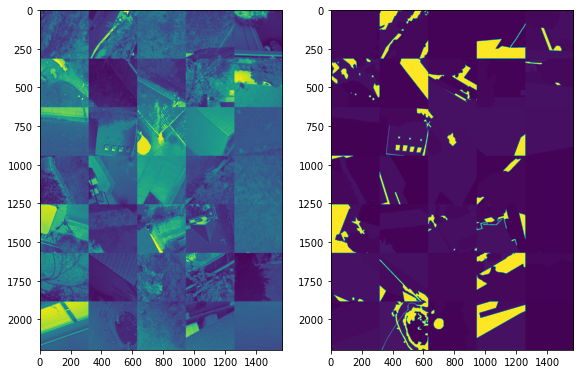

In [ ]:
%time
%timeit
start = time.time()






# img_final, mask_final, depth_final= produce_aug_img_2(train_images)
img_final, mask_final = produce_aug_img_2(train_images)



end = time.time()
print('Time taken ', end-start,' seconds')


# print(np.unique(mask_final), (mask_final==255).sum()/(2200*1500)*100)
# print((depth_final==0).sum()/(2200*1500)*100)

plt.figure(figsize=(20,20))

plt.subplot(1,4,1)
plt.imshow(img_final)
plt.subplot(1,4,2)
plt.imshow(mask_final)
# # # plt.subplot(1,4,3)
# # # plt.imshow(depth_final)

In [ ]:
image_corrected_path, mask_corrected_path

('/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/',
 '/content/drive/MyDrive/Colab Notebooks/suadd/semantic_annotations_corrected/')

In [ ]:
len(train_images)

4127

In [ ]:
%time
%timeit
start = time.time()

for i in range(10000):
  img_final, mask_final = produce_aug_img_2(train_images)

  img_save_path = image_corrected_path + 'aug__314x314__'+str(i) + '.png'
  msk_save_path = mask_corrected_path  + 'aug__314x314__'+str(i) + '.png'

  cv2.imwrite(img_save_path, img_final)
  cv2.imwrite(msk_save_path, mask_final)

  if i % 1000 == 0:
    print(i)
    end = time.time()
    print('Time taken ', end-start,' seconds')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs
0
Time taken  8.762301445007324  seconds
1000
Time taken  3260.72513794899  seconds
2000
Time taken  5819.878500699997  seconds
3000
Time taken  8509.302569150925  seconds
4000
Time taken  11217.897763729095  seconds
5000
Time taken  13874.867489814758  seconds
6000
Time taken  16482.148894548416  seconds
7000
Time taken  19207.697377204895  seconds
8000
Time taken  21902.88624215126  seconds
9000
Time taken  24584.006756067276  seconds


In [ ]:
# Animal / wire and snow

# Animal / wire and snow

In [ ]:
# cv2.imread(msk_save_path)

In [ ]:
# building animal / wire images:

In [6]:
imagelist = [
# '1916de35835548a8950b114d179502a3-1617745442700001171.png', no animal: two humans and two high vegetation
'25f0f91cc29f46e8aa7a58375fc9374c-1628196305200003571.png',
'4914c21abf784dee81d54486815f31f2-1623775421100001302.png',
'3adcd2baeebe44eaa1e207fddc5abd40-1629663148100009522.png',
'5e6a6ea21f5e498486acc453eb7bf756-1621371215600006535.png',
'804be9dcbfd1482e99725d423c10df9e-1618421859900005380.png',
'601472f5d0b34b028d7068b63e75b0fd-1620249719900018287.png',
'65b472b814d947a28581ac1b10fb026c-1623774903000005469.png',
'65b472b814d947a28581ac1b10fb026c-1623774931300006029.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764371200006912.png',
'15be0a6408284c1783338aea7bb7893c-1622051029500007434.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279561400004007.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323919800003977.png',
'32f120c5305a4c5bbfe8fd15eaa52d6e-1620064113600005652.png',
'db7a193641734182aab1789f6fd51490-1628196614700001554.png',
'4914c21abf784dee81d54486815f31f2-1623775444600001766.png',
'0d6ab5b308994a6e86321f4d4a34db86-1622757640800007455.png',
'4914c21abf784dee81d54486815f31f2-1623775417200001205.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323900400003579.png',
'490999536d194a53bde8ddcff6994824-1617210411200005237.png',
'9b5d64b124404976910296c14616b457-1654620544400010147.png',
'a219be9df80b4431bd952700b840262f-1622741999200010280.png',
'ffa00bc2e87d4c3a85ce2ef5527b34b8-1632162006300002966.png',
'f7d74954c6b74475b601bb8af1ce00d1-1632243691100003384.png',
'fc826f0980244d0893e0e4a30fc4b03a-1620683519100003783.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196277400003011.png',
'65b472b814d947a28581ac1b10fb026c-1623774894900005310.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196299000003461.png',
'fc826f0980244d0893e0e4a30fc4b03a-1620683521700003847.png',
'5ee5bfff18fd40d6944a70478645279b-1619645855500004322.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278960500002777.png',
'bf1925dff2f942b1a3d01462661be818-1632161453500006885.png',
'db7a193641734182aab1789f6fd51490-1628196611900001497.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764350300006497.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065402000002304.png',
'a219be9df80b4431bd952700b840262f-1622741984300009986.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279548200003726.png',
'490999536d194a53bde8ddcff6994824-1617210407200005147.png',
'4914c21abf784dee81d54486815f31f2-1623775409300001059.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941653200005820.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547941600003087.png',
'f7d74954c6b74475b601bb8af1ce00d1-1632243678500003121.png',
'3adcd2baeebe44eaa1e207fddc5abd40-1629663132200009225.png',
'1716b622a6cb42828e61a5546317a437-1616446324100003583.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065411800002502.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196266500002806.png',
'891d24c5cee840f3941a2bb9d7e46070-1622742568000004663.png',
'0b23fb62b2624c7588da634875907631-1623259921000003601.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548503300003403.png',
'9a71d82b827e4fd6acad4d6137391447-1619645290800009052.png',
'db7a193641734182aab1789f6fd51490-1628196609000001457.png',
'bf1925dff2f942b1a3d01462661be818-1632161474900007313.png',
'601472f5d0b34b028d7068b63e75b0fd-1620249706300018018.png',
'fc826f0980244d0893e0e4a30fc4b03a-1620683464100002699.png',
'd1c6c9d991c246aa99f266f4aa65caa7-1621446561900010416.png',
'601472f5d0b34b028d7068b63e75b0fd-1620249709400018080.png',
# '50d640234030421f8bde2868d97b64bd-1618945019800006018.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241957700003974.png',
'2017182b09754d29b26237562006e744-1620143910100004556.png',
'65b472b814d947a28581ac1b10fb026c-1623774886800005156.png',
'5ee5bfff18fd40d6944a70478645279b-1619645823700003686.png',
'23233fa8c58d452fbbbe5314961aa610-1620063430700006848.png',
'7c271774b5d943038775112dc2dd7af8-1623362738300006540.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065386100001997.png',
'891d24c5cee840f3941a2bb9d7e46070-1622742564400004599.png',
'd1c6c9d991c246aa99f266f4aa65caa7-1621446539600009970.png',
'9a71d82b827e4fd6acad4d6137391447-1619645258400008398.png',
'7163d1e941434aba8d6edb1a4794c98d-1617912898100003202.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941619700005142.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941608500004918.png',
'f7d74954c6b74475b601bb8af1ce00d1-1632243675400003049.png',
'3adcd2baeebe44eaa1e207fddc5abd40-1629663120300008984.png',
'10f786d3736948d78f0185ae781004a5-1622758193900004710.png',
'bf1925dff2f942b1a3d01462661be818-1632161446400006729.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941617400005091.png',
'93807df84a824cdc9127a5b3674cd630-1630863022500001452.png',
'23233fa8c58d452fbbbe5314961aa610-1620063427800006782.png',
'7c271774b5d943038775112dc2dd7af8-1623362717500006117.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323877700003126.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548491400003183.png',
'490999536d194a53bde8ddcff6994824-1617210399400005009.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810009700012934.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547927400002788.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764345100006404.png',
'601472f5d0b34b028d7068b63e75b0fd-1620249701800017923.png',
'906e54ead2bd4550822ceac614140c97-1629662344000011941.png',
'891d24c5cee840f3941a2bb9d7e46070-1622742560900004527.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196263400002752.png',
'a219be9df80b4431bd952700b840262f-1622741977700009856.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323876100003087.png',
'93807df84a824cdc9127a5b3674cd630-1630863018400001375.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278943000002430.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547925600002765.png',
'0d6ab5b308994a6e86321f4d4a34db86-1622757586500006367.png',
'906e54ead2bd4550822ceac614140c97-1629662345200011986.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065382500001910.png',
'3af7f11f038c4d8187bc0df505d6acfa-1644529920200016287.png',
'9b5d64b124404976910296c14616b457-1654620516900009588.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278940100002364.png', # series of wire with missing humans under wires ? 
'0b23fb62b2624c7588da634875907631-1623259909700003393.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548487400003086.png',
# '6d8ed4d362f94d20a80a026f52a4f4fd-1660188025100002674.png',   ## not an animal but high vegetation
'601472f5d0b34b028d7068b63e75b0fd-1620249741100018719.png',
'3adcd2baeebe44eaa1e207fddc5abd40-1629663116400008907.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764339900006292.png',
'd1c6c9d991c246aa99f266f4aa65caa7-1621446534100009845.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279542400003621.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278935700002290.png',
'7c271774b5d943038775112dc2dd7af8-1623362711000005986.png',
'10f786d3736948d78f0185ae781004a5-1622758189800004630.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065380000001871.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323872900003034.png',
'0d6ab5b308994a6e86321f4d4a34db86-1622757582000006294.png',
'9b5d64b124404976910296c14616b457-1654620515600009557.png',
'10f786d3736948d78f0185ae781004a5-1622758187700004580.png',
'2017182b09754d29b26237562006e744-1620143904200004432.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279538000003535.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548483400003014.png',
'23233fa8c58d452fbbbe5314961aa610-1620063420600006641.png',
'3adcd2baeebe44eaa1e207fddc5abd40-1629663111100008788.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547918500002631.png',
'906e54ead2bd4550822ceac614140c97-1629662338000011836.png',
'5ee5bfff18fd40d6944a70478645279b-1619645807800003356.png',
'9b5d64b124404976910296c14616b457-1654620513100009522.png',
'5bcde0ccaef84b2692897574e4745b41-1622064936500003768.png',
'cbe292d8482f436a81d8115a6711352f-1633627447200001030.png',
'9a71d82b827e4fd6acad4d6137391447-1619645251400008261.png',
'9a71d82b827e4fd6acad4d6137391447-1619645249100008219.png',

]


In [7]:
image_corrected_path, mask_corrected_path

('/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/',
 '/content/drive/MyDrive/Colab Notebooks/suadd/semantic_annotations_corrected/')

In [8]:
imgpath = imagelist[11] #'8d0b987dba1b41d1b1ffeee623337946-1621278935700002290.png'


mask = mask_corrected_path + imgpath
mask = cv2.imread(mask)

mm = np.where(mask==4,1,0).astype('uint8')[:,:,0]
contours, hierarchy = cv2.findContours(mm.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

contours = max(contours, key = cv2.contourArea)
x,y,w,h = cv2.boundingRect(contours)
x,y,w,h

image_path = image_corrected_path + imgpath
image = cv2.imread(image_path)
imgrect = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

In [9]:
imagelist[10]

'748f7ecdd8434553a7a8d341eda4419e-1621279561400004007.png'

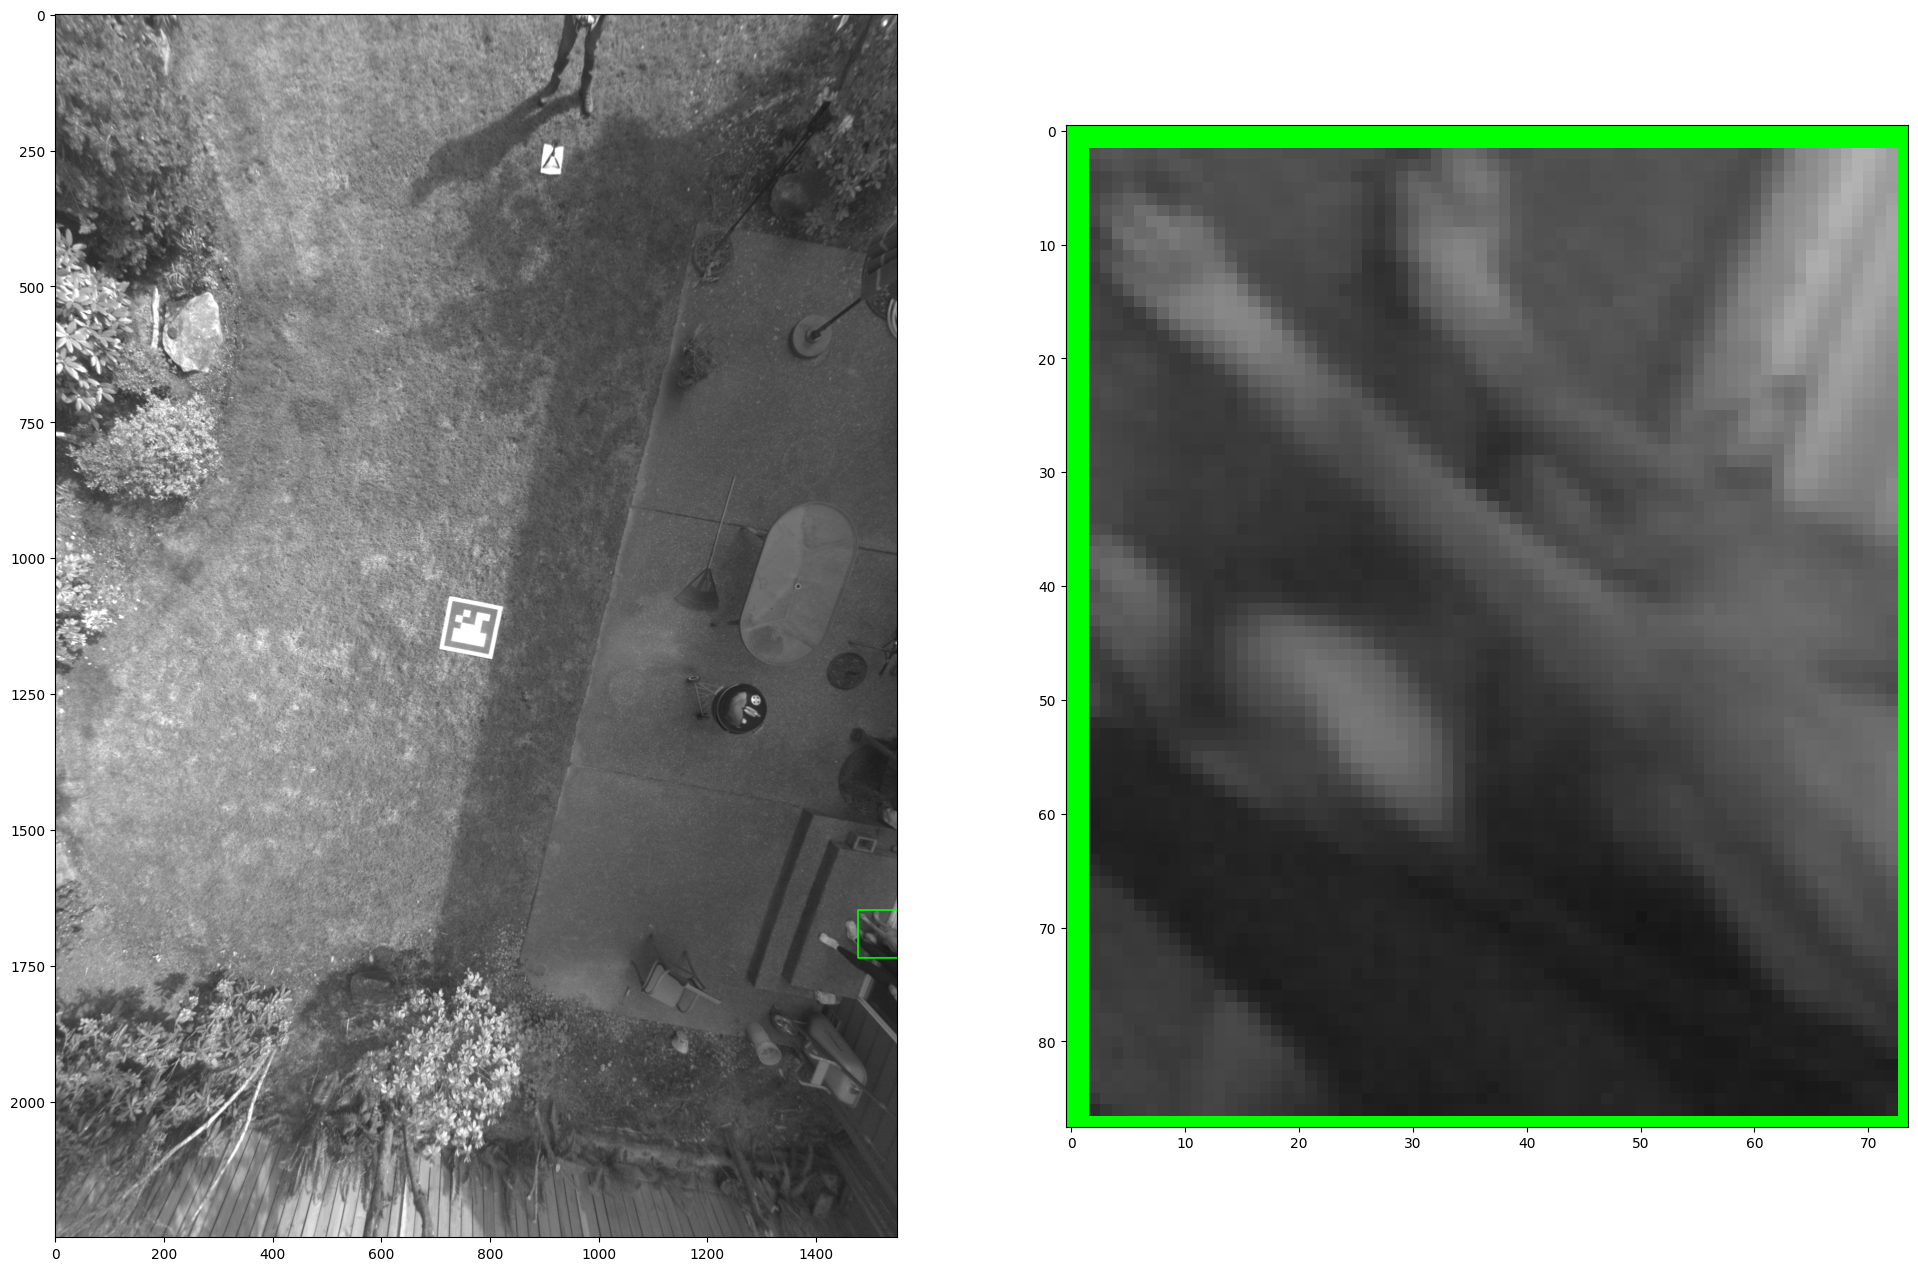

In [10]:

plt.figure(figsize=(50,50))
# print(np.where(mask==1,1,0).sum())
plt.subplot(1,4,1)
plt.imshow(imgrect)
plt.subplot(1,4,2)
plt.imshow(image[ y:y+h, x:x+w, :])

In [ ]:
chien_list = []
chien_dimw = []
chien_dimh = []
chien_list_crop = []

for path in imagelist:
    imgpath = path


    mask = src_mask_path + imgpath
    mask = cv2.imread(mask)[:,:,0]

    mm = np.where(mask==4,1,0).astype('uint8')
    contours, hierarchy = cv2.findContours(mm.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    contours = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(contours)
#     print(x,y,w,h)
    chien_dimw.append(w)
    chien_dimh.append(h)


    image_path = src_image_path + imgpath
    image = cv2.imread(image_path)
    imgrect = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    
    chien_list.append(image[ y:y+h, x:x+w, :])
    
    
    imgsize = mask.shape
    W, H =  imgsize[:2][::-1]
#     print(W,H)
    
    if x < 250:
        x1, x2 = 0, 500
    elif x > W-250:
        x1, x2 = W-500, W
    else:
        x1, x2 = x-250, x+250
        
        
   
    
    if y < 275:
        y1, y2 = 0, 550
    elif y > H-275:
        y1, y2 = H-550, H
    else:
        y1, y2 = y-275, y+275
        
    
#     print(x2-x1, y2-y1)
        
    chien_list_crop.append(image[ y1:y2, x1:x2, :])    

plt.figure(figsize=(150,150))
# print(np.where(mask==1,1,0).sum())
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(chien_list_crop[ii+16*2])

In [ ]:
plt.figure(figsize=(150,150))
# print(np.where(mask==1,1,0).sum())
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(chien_list_crop[ii+16*2])

In [ ]:
len(chien_list_crop)

125

In [ ]:
imagelist[57]

'65b472b814d947a28581ac1b10fb026c-1623774886800005156.png'

In [ ]:
chien_list = []
chien_dimw = []
chien_dimh = []
chien_list_crop_img, chien_list_crop_msk = [], []

for path in imagelist:
    imgpath = path


    mask = src_mask_path + imgpath
    mask = cv2.imread(mask)[:,:,0]

    mm = np.where(mask==4,1,0).astype('uint8')
    contours, hierarchy = cv2.findContours(mm.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    contours = max(contours, key = cv2.contourArea)
    x,y,w,h = cv2.boundingRect(contours)
#     print(x,y,w,h)
    chien_dimw.append(w)
    chien_dimh.append(h)


    image_path = src_image_path + imgpath
    image = cv2.imread(image_path)
    # imgrect = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    
    chien_list.append(image[ y:y+h, x:x+w, :])
    
    
    imgsize = mask.shape
    W, H =  imgsize[:2][::-1]
#     print(W,H)
    
    if x < 100:
        x1, x2 = 0, 200
    elif x > W-200:
        x1, x2 = W-200, W
    else:
        x1, x2 = x-100, x+100
        
        
   
    
    if y < 100:
        y1, y2 = 0, 200
    elif y > H-100:
        y1, y2 = H-200, H
    else:
        y1, y2 = y-100, y+100
        
    
#     print(x2-x1, y2-y1)
        
    chien_list_crop_img.append(image[ y1:y2, x1:x2, :])  
    chien_list_crop_msk.append(mask[ y1:y2, x1:x2])

In [ ]:
len(chien_list_crop_img), len(chien_list_crop_msk)

(125, 125)

In [ ]:
chien_list_crop_img[0].shape, chien_list_crop_msk[0].shape

((200, 200, 3), (200, 200))

In [ ]:
def randomFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)
    if np.random.random() < u:
        image = cv2.flip(image, 2)
        mask = cv2.flip(mask, 2)
    if np.random.random() < u:
        image = np.rot90(image,1)
        mask = np.rot90(mask,1)
    if np.random.random() < u:
        image = np.rot90(image,2)
        mask = np.rot90(mask,2)
    return image, mask

In [ ]:
# c

In [ ]:
img_scale = (2200, 1600, 3)



position = [(0,0),      (0,500),      (0,1000),      (0,1500),
            (500,0),      (500,500),      (500,1000),      (500,1500),
            (1000,0),      (1000,550),      (1000,1000),      (1000,1500),
            ]
import itertools
a = [200*i for i in range(11)]
b = [200*i for i in range(8)]
c = list(itertools.product(b,a))

position = c

for oo in range(500):

  possible_candidates = np.random.randint(126, size=88)


  img_final = np.zeros((img_scale))
  mask_final = np.zeros((img_scale[:2]))

  for i,pos in enumerate(position):

    k = possible_candidates[i]

    img_pos = chien_list_crop_img[k]
    msk_pos = chien_list_crop_msk[k]


    x1, y1, x2, y2 = pos[0], pos[1], pos[0]+200, pos[1]+200

    img_pos, msk_pos = randomFlip(img_pos, msk_pos)


    img_final[ y1:y2, x1:x2,] = img_pos
    mask_final[ y1:y2, x1:x2,] = msk_pos


  cv2.imwrite(image_corrected_path + 'animal_'+str(oo)+'.png', img_final.astype('uint8'))
  cv2.imwrite(mask_corrected_path  + 'animal_'+str(oo)+'.png', mask_final.astype('uint8'))

In [ ]:
mask_final.shape, img_final.shape

((2200, 1600), (2200, 1600, 3))

In [ ]:
image_corrected_path + 'animal_'+str(i)+'.png'

'/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/animal_87.png'

In [ ]:
possible_candidates

array([ 20,  11,  62,  29, 123, 110, 120,  87,  16,  30,  79,  46,  77,
        17,   7,  49,  59, 121,  60,  93,  85,  38,  89,  49, 100,  50,
       100,  84,  30,  43,  58,  64,  88,  32, 125,  95,  45,  15,  84,
        23,  22,  30,  75,  18,  56,  23,  72, 110, 116, 109,  40, 110,
        85, 109,  72,  26, 124,  69,  20,  92,  30,  51,  51,  70, 101,
        99,  27, 120,  75,  80,  64,  47, 104,  96,  56,  64,  39, 125,
        10,   1,  31, 120,  53,  26,  38,  88,  93,  84])

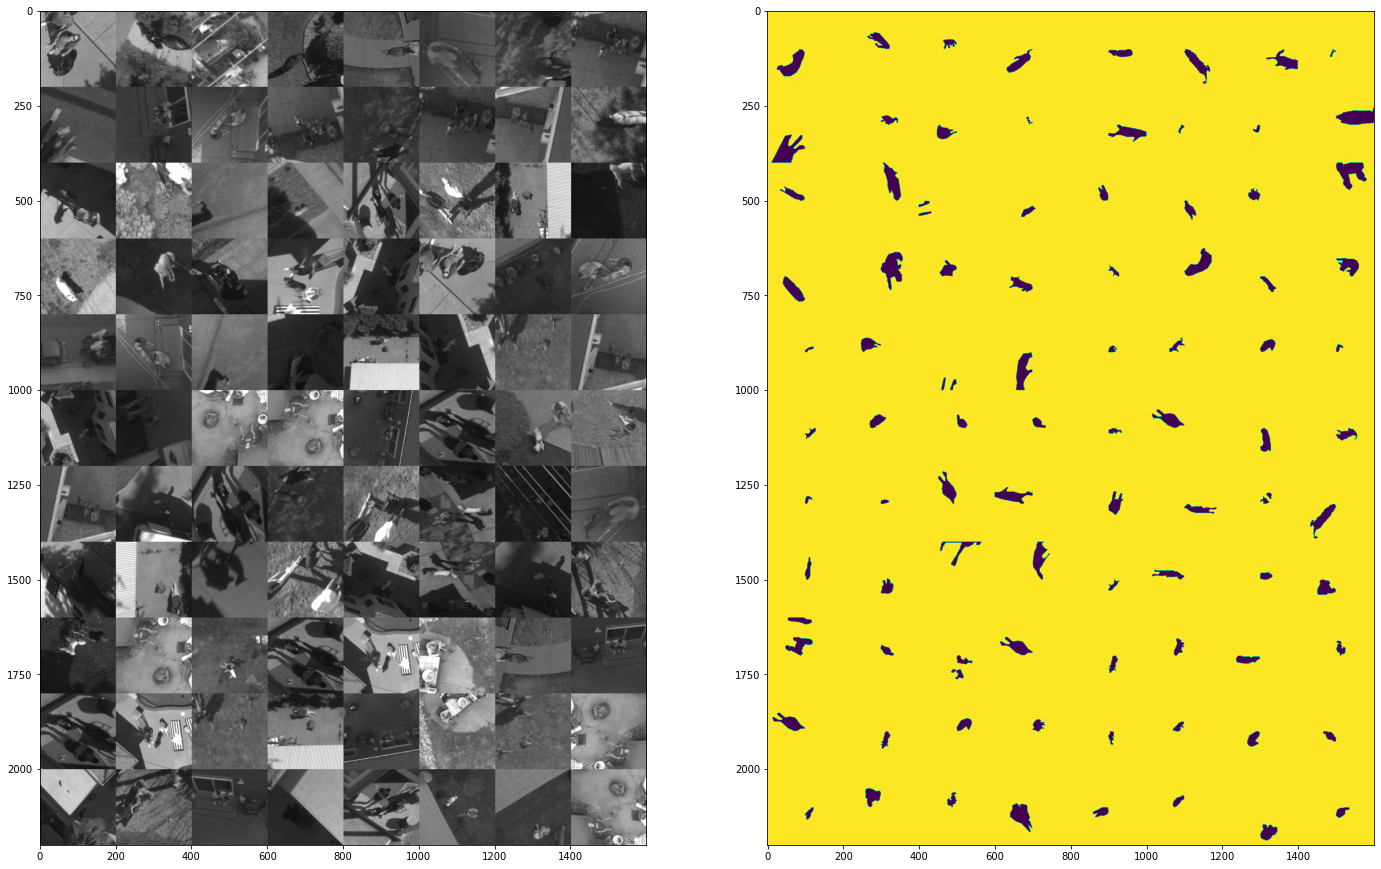

In [ ]:
plt.figure(figsize=(50,50))
# print(np.where(mask==1,1,0).sum())
plt.subplot(1,4,1)
plt.imshow(img_final.astype('uint8'))
plt.subplot(1,4,2)
plt.imshow(np.where(mask_final==4, 0,1))

In [ ]:
snowimagelist =[
# '064d495622994e1ab3dfda24db78addf-1660187328000010228.png', #no snow
'072b9f864f8f445485df414fbed70cd4-1613601058600003328.png',
'072b9f864f8f445485df414fbed70cd4-1613601062100003400.png',
'072b9f864f8f445485df414fbed70cd4-1613601066700003487.png',
'072b9f864f8f445485df414fbed70cd4-1613601069100003528.png',
'072b9f864f8f445485df414fbed70cd4-1613601079600003740.png',
'16efacce0e824e6f9e15149e0d9c57a0-1613515284400005935.png',
'16efacce0e824e6f9e15149e0d9c57a0-1613515287700006017.png',
'16efacce0e824e6f9e15149e0d9c57a0-1613515291000006063.png',
'16efacce0e824e6f9e15149e0d9c57a0-1613515299800006245.png',
'16efacce0e824e6f9e15149e0d9c57a0-1613515308600006437.png',
# '1716b622a6cb42828e61a5546317a437-1616446321300003515.png', #no snow
'20b88c9d52184113a2ee356ab14754a4-1613513847700009573.png',
'20b88c9d52184113a2ee356ab14754a4-1613513850600009620.png',
'20b88c9d52184113a2ee356ab14754a4-1613513854800009713.png',
'20b88c9d52184113a2ee356ab14754a4-1613513857100009748.png',
'20b88c9d52184113a2ee356ab14754a4-1613513861300009846.png',
'26d2a65804bf4858b94eb1121185c174-1613600569500010897.png',
'26d2a65804bf4858b94eb1121185c174-1613600575600011029.png',
'26d2a65804bf4858b94eb1121185c174-1613600582500011166.png',
'26d2a65804bf4858b94eb1121185c174-1613600584800011218.png',
'26d2a65804bf4858b94eb1121185c174-1613600589400011288.png',
'2f7bcc19c27d4098b27698cf3db768c0-1613586178700002593.png',
'2f7bcc19c27d4098b27698cf3db768c0-1613586185100002707.png',
'2f7bcc19c27d4098b27698cf3db768c0-1613586189900002805.png',
'2f7bcc19c27d4098b27698cf3db768c0-1613586207600003153.png',
'2f7bcc19c27d4098b27698cf3db768c0-1613586222000003452.png',
'30ed15a9d0564ff384747d86e4742fcb-1613514530700006197.png',
'30ed15a9d0564ff384747d86e4742fcb-1613514533100006226.png',
'30ed15a9d0564ff384747d86e4742fcb-1613514540100006374.png',
'30ed15a9d0564ff384747d86e4742fcb-1613514554300006670.png',
'30ed15a9d0564ff384747d86e4742fcb-1613514562600006817.png',
'3472406edf6e4d3896db1a11cf5fbd26-1613585356200005186.png',
'3472406edf6e4d3896db1a11cf5fbd26-1613585358600005233.png',
'3472406edf6e4d3896db1a11cf5fbd26-1613585364200005340.png',
'3472406edf6e4d3896db1a11cf5fbd26-1613585369700005441.png',
'3472406edf6e4d3896db1a11cf5fbd26-1613585374500005534.png',
'490999536d194a53bde8ddcff6994824-1617210399400005009.png',
'6c28c151db94488a91952108f23deaa8-1617811386500031591.png',
'6c28c151db94488a91952108f23deaa8-1617811389100031661.png',
'7743e90f1205464696e4f72ac2f30108-1613586761200003194.png',
'7743e90f1205464696e4f72ac2f30108-1613586766400003286.png',
'7743e90f1205464696e4f72ac2f30108-1613586772800003423.png',
'7743e90f1205464696e4f72ac2f30108-1613586789700003760.png',
'7743e90f1205464696e4f72ac2f30108-1613586794800003873.png',
'91f219c5e5314cdc987b06d305ff884a-1613597214200003935.png',
'91f219c5e5314cdc987b06d305ff884a-1613597216400003981.png',
'91f219c5e5314cdc987b06d305ff884a-1613597223400004118.png',
'91f219c5e5314cdc987b06d305ff884a-1613597225600004163.png',
'91f219c5e5314cdc987b06d305ff884a-1613597239400004436.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596609000009687.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596611200009727.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596615000009814.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596617700009854.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596620500009907.png',
'9fa0676490b744c1b04f205704f91d43-1614811731500009710.png',
'a65d20d4d98f4d4bad3f395a2c5fcc87-1615327880600007875.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601722800006312.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601725600006367.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601729900006435.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601731300006488.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601748400006822.png',
]

In [ ]:
len(snowimagelist)

60

In [ ]:
imgpath = snowimagelist[11] #'8d0b987dba1b41d1b1ffeee623337946-1621278935700002290.png'


mask = mask_corrected_path + imgpath
mask = cv2.imread(mask)

mm = np.where(mask==15,1,0).astype('uint8')[:,:,0]
contours, hierarchy = cv2.findContours(mm.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

contours = max(contours, key = cv2.contourArea)
x,y,w,h = cv2.boundingRect(contours)
x,y,w,h

image_path = image_corrected_path + imgpath
image = cv2.imread(image_path)
imgrect = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

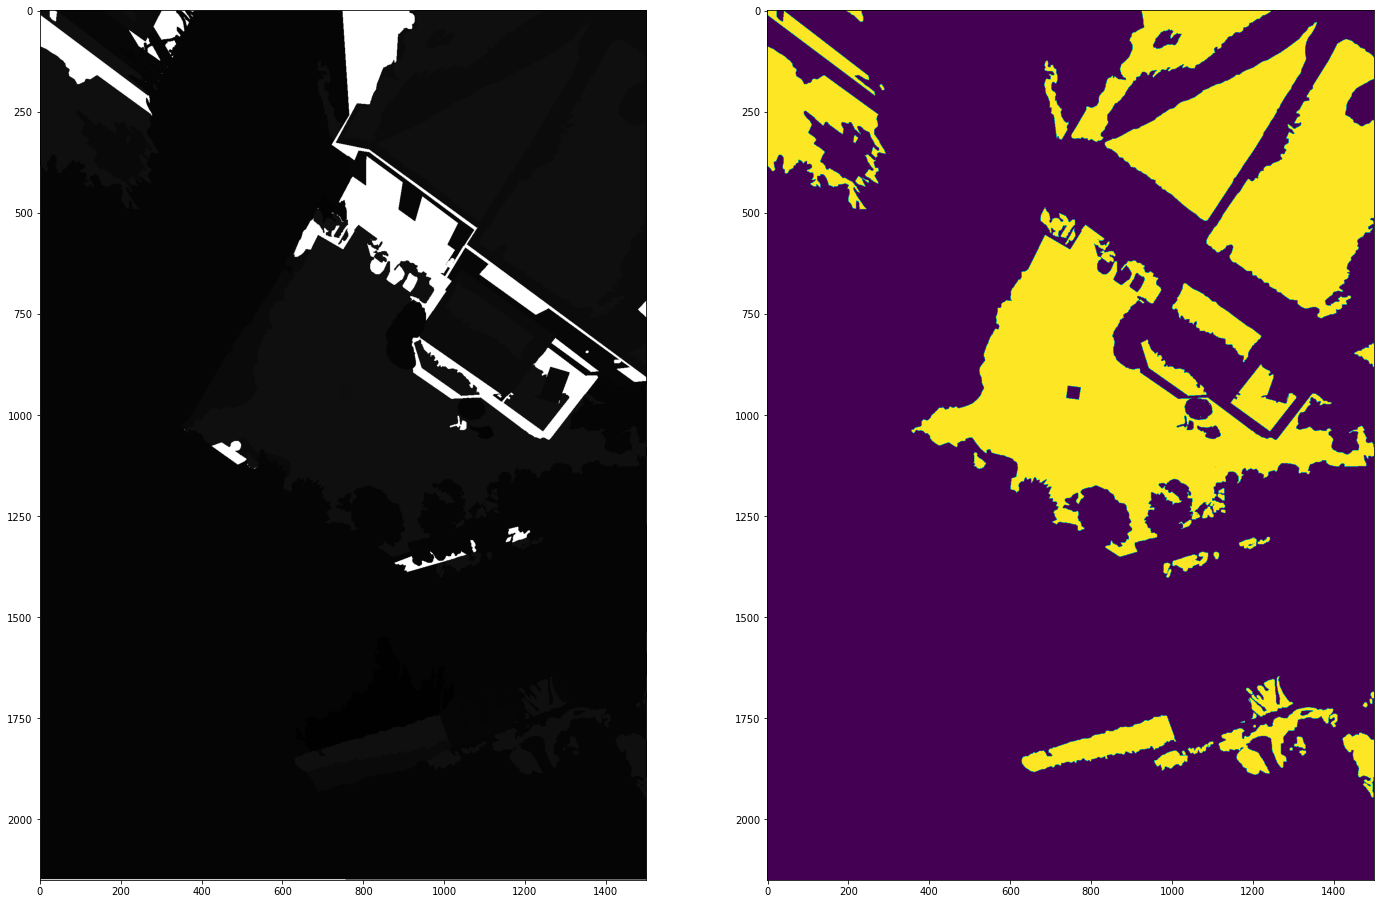

In [ ]:
plt.figure(figsize=(50,50))
# print(np.where(mask==1,1,0).sum())
plt.subplot(1,4,1)
plt.imshow(mask)
plt.subplot(1,4,2)
plt.imshow(mm)

In [ ]:
neige_list = []
neige_dimw = []
neige_dimh = []
neige_list_crop = []

a = 0

for path in  snowimagelist:
    imgpath = path


    mask_path = src_mask_path + imgpath
    mask = cv2.imread(mask_path)[:,:,0]

    mm = np.where(mask==15,1,0).astype('uint8')
    print(path, ' ',mm.sum())
    try:
      contours, hierarchy = cv2.findContours(mm.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

      for contour in contours:
        # contours = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(contour)

        if w*h > 250:
          a += 1

      #     print(x,y,w,h)
          neige_dimw.append(w)
          neige_dimh.append(h)


          image_path = src_image_path + imgpath
          image = cv2.imread(image_path)
          imgrect = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

          # print('w,h', w,h)
          
          # neige_list.append(image[ y:y+h, x:x+w, :])
          
          
          imgsize = mask.shape
          W, H =  imgsize[:2][::-1]
          # print(W,H)
          
          if x < 100:
              x1, x2 = 0, 200
          elif x > W-100:
              x1, x2 = W-200, W
          else:
              x1, x2 = x-100, x+100
              
              
        
          
          if y < 100:
              y1, y2 = 0, 200
          elif y > H-100:
              y1, y2 = H-200, H
          else:
              y1, y2 = y-100, y+100
              
          
      #     print(x2-x1, y2-y1)
              
          # neige_list_crop.append(image[ y1:y2, x1:x2, :])    
          neige_list_crop.append([path, y1,y2, x1,x2])  
    except:
      print(path)

# plt.figure(figsize=(150,150))
# # print(np.where(mask==1,1,0).sum())
# for ii in range(16):
#     plt.subplot(4,4,ii+1)
#     plt.imshow(neige_list_crop[ii+16*2])

072b9f864f8f445485df414fbed70cd4-1613601058600003328.png   427682
072b9f864f8f445485df414fbed70cd4-1613601062100003400.png   566626
072b9f864f8f445485df414fbed70cd4-1613601066700003487.png   638634
072b9f864f8f445485df414fbed70cd4-1613601069100003528.png   585252
072b9f864f8f445485df414fbed70cd4-1613601079600003740.png   893975
16efacce0e824e6f9e15149e0d9c57a0-1613515284400005935.png   690862
16efacce0e824e6f9e15149e0d9c57a0-1613515287700006017.png   681498
16efacce0e824e6f9e15149e0d9c57a0-1613515291000006063.png   676175
16efacce0e824e6f9e15149e0d9c57a0-1613515299800006245.png   1324226
16efacce0e824e6f9e15149e0d9c57a0-1613515308600006437.png   1587046
20b88c9d52184113a2ee356ab14754a4-1613513847700009573.png   660479
20b88c9d52184113a2ee356ab14754a4-1613513850600009620.png   743099
20b88c9d52184113a2ee356ab14754a4-1613513854800009713.png   657341
20b88c9d52184113a2ee356ab14754a4-1613513857100009748.png   852680
20b88c9d52184113a2ee356ab14754a4-1613513861300009846.png   1648516
26d2a65

In [ ]:
len(neige_list_crop)

1949

In [ ]:
img_scale = (2200, 1600, 3)



position = [(0,0),      (0,500),      (0,1000),      (0,1500),
            (500,0),      (500,500),      (500,1000),      (500,1500),
            (1000,0),      (1000,550),      (1000,1000),      (1000,1500),
            ]
import itertools
a = [200*i for i in range(11)]
b = [200*i for i in range(8)]
c = list(itertools.product(b,a))

position = c

for oo in range(500):

  possible_candidates = np.random.randint(1949, size=88)


  img_final = np.zeros((img_scale))
  mask_final = np.zeros((img_scale[:2]))

  for i,pos in enumerate(position):

    k = possible_candidates[i]

    neige_kit = neige_list_crop[k]

    p, y1,y2, x1,x2 = neige_kit

    image_path = src_image_path + p
    img = cv2.imread(image_path)
    img_pos = img[y1:y2, x1:x2, :]
    mask_path = src_mask_path + p
    msk = cv2.imread(mask_path)[:,:,0]
    msk_pos = msk[y1:y2, x1:x2]


    # img_pos = chien_list_crop_img[k]
    # msk_pos = chien_list_crop_msk[k]


    x1, y1, x2, y2 = pos[0], pos[1], pos[0]+200, pos[1]+200

    img_pos, msk_pos = randomFlip(img_pos, msk_pos)


    img_final[ y1:y2, x1:x2,] = img_pos
    mask_final[ y1:y2, x1:x2,] = msk_pos


  cv2.imwrite(image_corrected_path + 'neige_'+str(oo)+'.png', img_final.astype('uint8'))
  cv2.imwrite(mask_corrected_path  + 'neige_'+str(oo)+'.png', mask_final.astype('uint8'))

In [ ]:
image_corrected_path + 'neige_'+str(oo)+'.png'

'/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/neige_499.png'

In [ ]:
mask_final.shape

(2200, 1600)

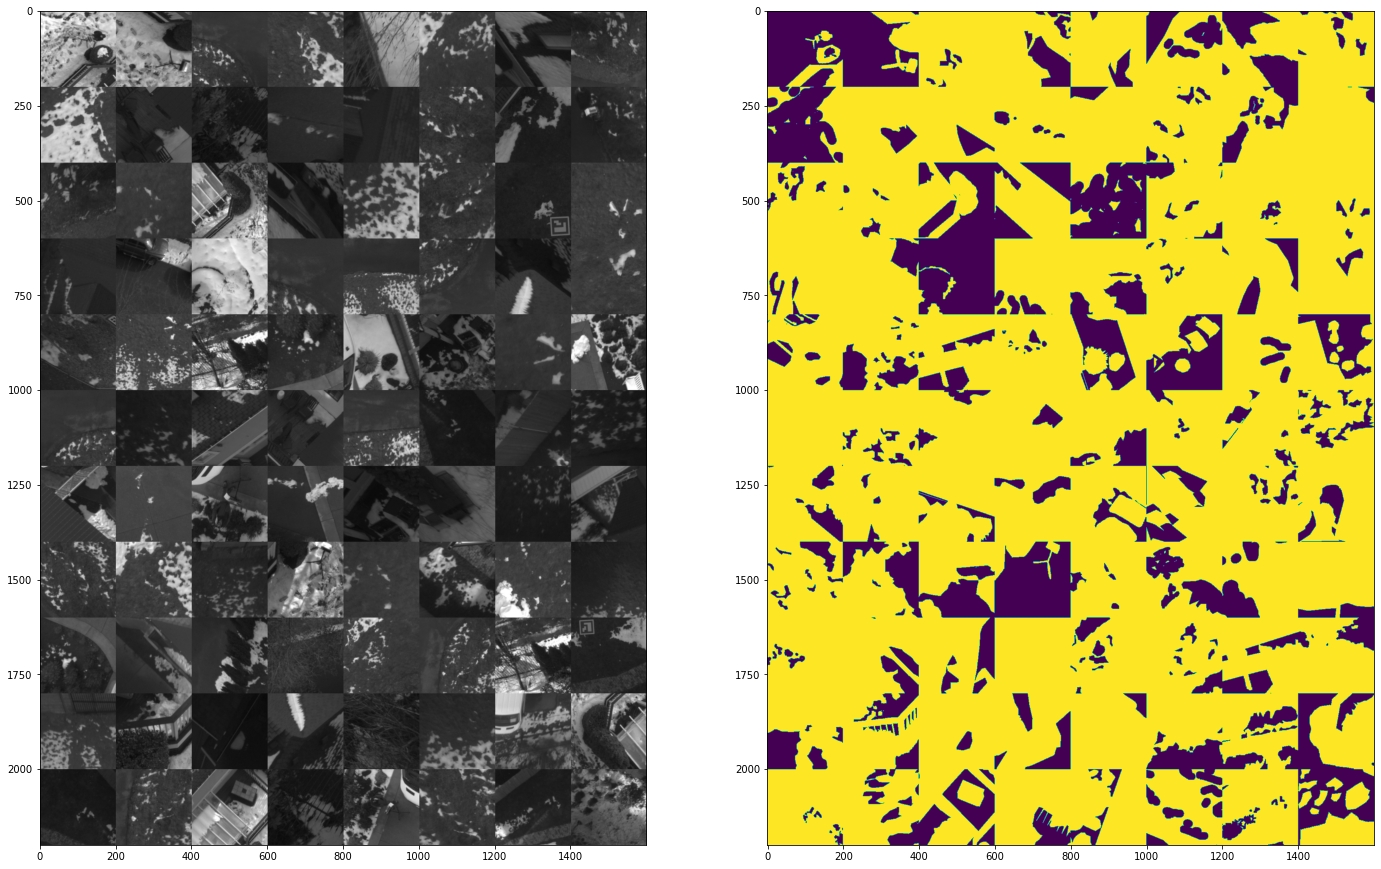

In [ ]:
plt.figure(figsize=(50,50))
# print(np.where(mask==1,1,0).sum())
plt.subplot(1,4,1)
plt.imshow(img_final.astype('uint8'))
plt.subplot(1,4,2)
plt.imshow(np.where(mask_final==15, 0,1))

In [ ]:
wireimagelist = [
'072b9f864f8f445485df414fbed70cd4-1613601058600003328.png',
'0b23fb62b2624c7588da634875907631-1623259906500003313.png',
'0b23fb62b2624c7588da634875907631-1623259921000003601.png',
'0b66b225b3cd460a932d7997666c69cc-1654619801900005458.png',
'0b66b225b3cd460a932d7997666c69cc-1654619803500005499.png',
'0b66b225b3cd460a932d7997666c69cc-1654619804300005511.png',  ## wire annotation is catatrophic
'0b66b225b3cd460a932d7997666c69cc-1654619806300005532.png',
'0b66b225b3cd460a932d7997666c69cc-1654619808300005578.png',
'0ddc87cbc3fd4673b926b80b708785cf-1614810875200010582.png',
'0ddc87cbc3fd4673b926b80b708785cf-1614810880400010706.png',
'0ddc87cbc3fd4673b926b80b708785cf-1614810883900010768.png',
'0ddc87cbc3fd4673b926b80b708785cf-1614810912000011323.png',
'1012f99c2c6149fd8d9673bdf54155d5-1616446840900003156.png',
'1012f99c2c6149fd8d9673bdf54155d5-1616446846600003265.png', ## wire too fat
'1012f99c2c6149fd8d9673bdf54155d5-1616446850800003345.png',
'1012f99c2c6149fd8d9673bdf54155d5-1616446852900003400.png',
'10ccc04a238946478a1c8b0c824ff9d3-1621447924900006139.png',
'10ccc04a238946478a1c8b0c824ff9d3-1621447927700006181.png',
'10ccc04a238946478a1c8b0c824ff9d3-1621447933200006292.png',
'10ccc04a238946478a1c8b0c824ff9d3-1621447937300006370.png',
'10d3f6ed2ad3455eb843abba3d99681f-1619550447800005616.png',
'10d3f6ed2ad3455eb843abba3d99681f-1619550449000005637.png',
'10d3f6ed2ad3455eb843abba3d99681f-1619550454700005739.png',
'10d3f6ed2ad3455eb843abba3d99681f-1619550457900005818.png',
'14c532a8627845af80a102597063b072-1621449119600012235.png',
'14c532a8627845af80a102597063b072-1621449123600012307.png',
'14c532a8627845af80a102597063b072-1621449129100012409.png',
'14c532a8627845af80a102597063b072-1621449131800012457.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901439400001792.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901444900001918.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901448600001974.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901456000002133.png',
'1b709866c00444cb81da6548774c40c9-1623776518500002644.png',
'1c4b651a263f41c791776fee50e4fca6-1612396205200010860.png',
'1d00b0a3a3f643f1ae268f87f3fd77f7-1614808722300010464.png',
'1d00b0a3a3f643f1ae268f87f3fd77f7-1614808727600010569.png',
'1d00b0a3a3f643f1ae268f87f3fd77f7-1614808728800010585.png',
'2017182b09754d29b26237562006e744-1620143904200004432.png',
'2017182b09754d29b26237562006e744-1620143910100004556.png',
'2017182b09754d29b26237562006e744-1620143914000004621.png',
'23233fa8c58d452fbbbe5314961aa610-1620063420600006641.png',
'26d2a65804bf4858b94eb1121185c174-1613600569500010897.png',
'26d2a65804bf4858b94eb1121185c174-1613600575600011029.png',
'283c221560de4260b9de627416669e53-1627405370600001532.png',
'283c221560de4260b9de627416669e53-1627405376600001645.png',
'283c221560de4260b9de627416669e53-1627405380300001716.png',
'283c221560de4260b9de627416669e53-1627405384100001779.png',
'2926994c8b60434ea9b9d6886f359fc3-1619109308700004742.png',
'2926994c8b60434ea9b9d6886f359fc3-1619109318300004941.png',
'2926994c8b60434ea9b9d6886f359fc3-1619109322200005021.png',
'29406ccf164e47f381fdd5d027576276-1625161960100008763.png',
'29406ccf164e47f381fdd5d027576276-1625161963900008845.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548483400003014.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548487400003086.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548491400003183.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548503300003403.png',
'295d398b4e2142ef91a38ea9576fd1d3-1619110678900004328.png',
'2d000465163546eaa8287ab57c091a9d-1619718229600006697.png',
'2edb4632d8704502b777c84371521b39-1619462428400005691.png',
'2edb4632d8704502b777c84371521b39-1619462432000005740.png',
'2edb4632d8704502b777c84371521b39-1619462439400005895.png',
'2edb4632d8704502b777c84371521b39-1619462441500005943.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624900983000003713.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624900986100003762.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624900989200003837.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624901010800004271.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624901023100004499.png',
'3170e46abf8e4974bb0578b435743366-1617214532400014689.png',
'32f120c5305a4c5bbfe8fd15eaa52d6e-1620064089500005177.png',
'344f520a2b0c407e9b22a516e03f49e9-1619647007200004576.png',
'347438dba2034c259383c1510a0ec5ce-1631209672400007819.png',
'347438dba2034c259383c1510a0ec5ce-1631209680700008000.png',
'353002bb8e6b48bc9d57a0558183c828-1626127552900011381.png',
'353002bb8e6b48bc9d57a0558183c828-1626127557700011474.png',
'369eb1158f204016bb6d4509a4f72005-1644861999900002933.png',
'3906767d75c44ba786670ea11765528f-1620680183500027396.png',
'3a915024fd15488cb4b8fe5762548a4b-1622586002700006871.png',
'3a915024fd15488cb4b8fe5762548a4b-1622586018400007185.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892341000001603.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892344500001679.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892348000001756.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892367400002140.png',
'412936ec1839402ca39745135e684364-1629667273300002772.png',
'412936ec1839402ca39745135e684364-1629667277900002871.png',
'412936ec1839402ca39745135e684364-1629667290800003115.png',
'4210f23d40a94f1cacf77bb684efef9c-1619119801800004837.png',
'4210f23d40a94f1cacf77bb684efef9c-1619119803400004866.png',
'45c5ef19885240b7ad9cd7a8b4cf546e-1619463055900005635.png',
'45c5ef19885240b7ad9cd7a8b4cf546e-1619463058300005683.png',
'45c5ef19885240b7ad9cd7a8b4cf546e-1619463062900005788.png',
'490999536d194a53bde8ddcff6994824-1617210399400005009.png',
'490999536d194a53bde8ddcff6994824-1617210407200005147.png',
'490999536d194a53bde8ddcff6994824-1617210411200005237.png',
'4914c21abf784dee81d54486815f31f2-1623775409300001059.png',
'4ac567d1a5f94b08a427e08878a1d383-1620149559400006934.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915979700008832.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915982700008893.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915983800008901.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876733900002273.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876737400002331.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876748000002539.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876767500002952.png',
'5039e0e97ac748e0b7c398bd84117a74-1606950267000013875.png',
'5039e0e97ac748e0b7c398bd84117a74-1606950288800014308.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444821700011054.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444827500011173.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444829700011214.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444836200011366.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444839100011413.png',
'54ae0a04fd24424ab9b73f1a804dcaee-1624551240600003033.png',
'54ae0a04fd24424ab9b73f1a804dcaee-1624551245200003110.png',
'54ae0a04fd24424ab9b73f1a804dcaee-1624551248300003178.png',
'54ae0a04fd24424ab9b73f1a804dcaee-1624551256000003341.png',
'54b153c4c626433abaf22786b0f76266-1618259679100014899.png',
'5bcde0ccaef84b2692897574e4745b41-1622064925000003538.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359118700006983.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359122400007044.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359134700007300.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359150800007605.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359152000007641.png',
'5ddfb70f423c40c4971219be81dee26f-1631916433900004081.png',
'5ddfb70f423c40c4971219be81dee26f-1631916440500004233.png',
'5ddfb70f423c40c4971219be81dee26f-1631916443000004269.png',
'5ddfb70f423c40c4971219be81dee26f-1631916446300004345.png',
'601472f5d0b34b028d7068b63e75b0fd-1620249701800017923.png',
'601472f5d0b34b028d7068b63e75b0fd-1620249706300018018.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764339900006292.png',
'62022db7d993471cb3086fad16ac54ff-1617046826000006261.png',
'7429a9c7b8d142899d668c958e7a8ef7-1619463647500002622.png',
'7429a9c7b8d142899d668c958e7a8ef7-1619463652600002736.png',
'7429a9c7b8d142899d668c958e7a8ef7-1619463668100003040.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279538000003535.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279542400003621.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279548200003726.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279561400004007.png',
'780c0807242849248970a0e3252fc3c4-1612397402900001580.png',
'782bab7c26c34eeeb108490b209c56a0-1619025238700002214.png',
'782bab7c26c34eeeb108490b209c56a0-1619025302500003494.png',
'7c271774b5d943038775112dc2dd7af8-1623362738300006540.png',
'7fe11e1aa96b42b7951f617db1bea549-1627595496600009534.png',
'7fe11e1aa96b42b7951f617db1bea549-1627595504800009681.png',
'7fe11e1aa96b42b7951f617db1bea549-1627595508900009762.png',
'7fe11e1aa96b42b7951f617db1bea549-1627595510300009807.png',
'804be9dcbfd1482e99725d423c10df9e-1618421830500004799.png',
'804be9dcbfd1482e99725d423c10df9e-1618421834400004865.png',
'804be9dcbfd1482e99725d423c10df9e-1618421838300004954.png',
'804be9dcbfd1482e99725d423c10df9e-1618421859900005380.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278522800006959.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278526900007023.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278529700007073.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278544800007394.png',
'88f4cb1a58574f3d845a3faf9f7000bd-1620062306700019595.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278935700002290.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278940100002364.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278943000002430.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278960500002777.png',
'91f219c5e5314cdc987b06d305ff884a-1613597216400003981.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596611200009727.png',
'93807df84a824cdc9127a5b3674cd630-1630863018400001375.png',
'93807df84a824cdc9127a5b3674cd630-1630863022500001452.png',
'93807df84a824cdc9127a5b3674cd630-1630863024500001493.png',
'93807df84a824cdc9127a5b3674cd630-1630863030600001597.png',
'942da0d4735f4dbeb80d7f03daf4e437-1621876243500005155.png',
'942da0d4735f4dbeb80d7f03daf4e437-1621876245000005192.png',
'942da0d4735f4dbeb80d7f03daf4e437-1621876251000005308.png',
'942da0d4735f4dbeb80d7f03daf4e437-1621876273400005769.png',
'942da0d4735f4dbeb80d7f03daf4e437-1621876282300005947.png',
'95be161966dc4ccf90ba1efbe1cb65a5-1619547412100010886.png',
'95be161966dc4ccf90ba1efbe1cb65a5-1619547415000010938.png',
'95be161966dc4ccf90ba1efbe1cb65a5-1619547417300010969.png',
'95be161966dc4ccf90ba1efbe1cb65a5-1619547422000011060.png',
'96fe8f9225c2416da801083de8b266ad-1618343215100009479.png',
'96fe8f9225c2416da801083de8b266ad-1618343217300009511.png',
'96fe8f9225c2416da801083de8b266ad-1618343222200009613.png',
'96fe8f9225c2416da801083de8b266ad-1618343224300009645.png',
'9870a475e7934cc6bc85aea6bdf80d93-1625162711000005586.png',
'98fdd7d3fe50494583aa81092e5a08da-1631204780100002098.png',
'98fdd7d3fe50494583aa81092e5a08da-1631204783000002151.png',
'98fdd7d3fe50494583aa81092e5a08da-1631204788900002270.png',
'9b5d64b124404976910296c14616b457-1654620513100009522.png',
'9b5d64b124404976910296c14616b457-1654620515600009557.png',
'9b5d64b124404976910296c14616b457-1654620516900009588.png',
'9b5d64b124404976910296c14616b457-1654620544400010147.png',
'9db5dd4832df40cab0cb3126bd617be5-1626298636100006417.png',
'9fa0676490b744c1b04f205704f91d43-1614811725800009590.png',
'9fa0676490b744c1b04f205704f91d43-1614811730000009669.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547918500002631.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547925600002765.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547927400002788.png',
'9fb3f1b0c18b47d9ab437c383e3112aa-1619547941600003087.png',
'a219be9df80b4431bd952700b840262f-1622741974400009778.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445433800005509.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445435700005536.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445440000005625.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445443200005688.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941608500004918.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941617400005091.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941619700005142.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941653200005820.png',
'a531270d23a04a9eb9ae91d1be14b81d-1617729597600016091.png',
'a531270d23a04a9eb9ae91d1be14b81d-1617729603800016218.png',
'ab7d7eaa81f14841bf8e632c01550924-1619025815400002361.png',
'abbf4f2ec8224abbad5c6f09f8fb9551-1620145822500005010.png',
'abbf4f2ec8224abbad5c6f09f8fb9551-1620145826300005094.png',
'ad3b5f6a9893494682d1c560779837b7-1623259374400004673.png',
'ad3b5f6a9893494682d1c560779837b7-1623259376100004717.png',
'ad3b5f6a9893494682d1c560779837b7-1623259406300005327.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875569700017007.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875575100017125.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875580500017228.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875584400017296.png',
'b0fc8b368dfa446f826f76e32dfa6a28-1619110071600004469.png',
'b3b6aadfef4045b8881c7e9ef8550b9c-1612482189900004521.png',
'b3b6aadfef4045b8881c7e9ef8550b9c-1612482191400004553.png',
'b4556c0520b9486294ba24edb26be619-1630862699100003370.png',
'b4556c0520b9486294ba24edb26be619-1630862703700003462.png',
'b4556c0520b9486294ba24edb26be619-1630862707700003538.png',
'b4556c0520b9486294ba24edb26be619-1630862709000003575.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280555500004594.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280556200004605.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280560700004700.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280567100004826.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280567700004834.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404962600007403.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404963800007435.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404968400007508.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404971200007564.png',
'ba5487adfa3d4e09bea7d567b5faef52-1619108698300008597.png',
'bc0d101a71434c8795f381c1ada8e1e1-1620064803700009877.png',
'bf1925dff2f942b1a3d01462661be818-1632161439300006590.png',
'c320bd182af84adcb2805aae192b1708-1615924545300008347.png',
'c320bd182af84adcb2805aae192b1708-1615924546800008374.png',
'c320bd182af84adcb2805aae192b1708-1615924550700008452.png',
'c388e1394f6f4380a97b789a83782994-1620144473800003035.png',
'c388e1394f6f4380a97b789a83782994-1620144476600003114.png',
'c3a116194899455c90726103910f2540-1631204407300005462.png',
'c3a116194899455c90726103910f2540-1631204411800005550.png',
'c3a116194899455c90726103910f2540-1631204431200005945.png',
'c3a116194899455c90726103910f2540-1631204440200006128.png',
'c42fac0cf3e34db28ec914d134379255-1624900227900002014.png',
'c76edb7a237442398589e3238a1230a4-1612397820900000861.png',
'c950ca48417b45978580d22f4e980b1d-1629563393500002323.png',
'c950ca48417b45978580d22f4e980b1d-1629563398800002427.png',
'c950ca48417b45978580d22f4e980b1d-1629563425400002969.png',
'cdea1eed27654f2f88fcaa98fb551bcb-1626128177900005417.png',
'cdea1eed27654f2f88fcaa98fb551bcb-1626128184600005548.png',
'cdea1eed27654f2f88fcaa98fb551bcb-1626128187900005612.png',
'ceb085229d744390825819837ae20708-1621280068100003396.png',
'ceb085229d744390825819837ae20708-1621280070500003447.png',
'ceb085229d744390825819837ae20708-1621280073500003502.png',
'ceb085229d744390825819837ae20708-1621280079500003632.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601722800006312.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601725600006367.png',
'd1158187339b4068b191098195590cbb-1618942152300002719.png',
'd1158187339b4068b191098195590cbb-1618942156000002780.png',
'd1158187339b4068b191098195590cbb-1618942161500002906.png',
'd1158187339b4068b191098195590cbb-1618942178200003236.png',
'd1c12a0f14ca4394a11b026a2df9396d-1631210427500002207.png',
'd1c12a0f14ca4394a11b026a2df9396d-1631210434400002350.png',
'd1c12a0f14ca4394a11b026a2df9396d-1631210437900002415.png',
'd4399b6873b648898f06db70fa89c691-1619027064400003527.png',
'd4399b6873b648898f06db70fa89c691-1619027068100003581.png',
'd4399b6873b648898f06db70fa89c691-1619027077500003769.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619297300021273.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619299600021309.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619300000021325.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619303500021397.png',
'dacada20c4504b7f8a2f7ffbb4007fd0-1619026567700004163.png',
'db7a193641734182aab1789f6fd51490-1628196603300001333.png',
'ded7816c2be44b4eb7d06e2b62e520e2-1619024782500010164.png',
'ded7816c2be44b4eb7d06e2b62e520e2-1619024784000010198.png',
'ded7816c2be44b4eb7d06e2b62e520e2-1619024798900010497.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446444100012422.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446448300012506.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446454500012653.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446471300012967.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446498400013508.png',
'e1c678a8cd6d483596798ad0bdb79ce3-1620150102400003966.png',
'e429282023f246818ca8298a9febd770-1621277849600015121.png',
'e429282023f246818ca8298a9febd770-1621277852400015181.png',
'e429282023f246818ca8298a9febd770-1621277857200015286.png',
'e429282023f246818ca8298a9febd770-1621277862000015375.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241943600003680.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241945000003707.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241949200003787.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241957700003974.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241978900004385.png',
'e621402591c0488ca315279736e26396-1619111204200002569.png',
'e67f53b87b724bc894b633e8498a4c53-1619119252300006320.png',
'e67f53b87b724bc894b633e8498a4c53-1619119260900006477.png',
'e67f53b87b724bc894b633e8498a4c53-1619119263200006543.png',
'e7bc31f0df12478c9a01d5cfb2407ce4-1619027838500005172.png',
'e7bc31f0df12478c9a01d5cfb2407ce4-1619027841700005254.png',
'ea1f385224644c9bb1ca1f7e00deffce-1620143327300019696.png',
'ea1f385224644c9bb1ca1f7e00deffce-1620143331700019781.png',
'ea1f385224644c9bb1ca1f7e00deffce-1620143336000019869.png',
'ead7e12e0caf485fbaa0f14d93985ea1-1619035306600002261.png',
'ed4a3859216a48db8b6d04eed5aacdc5-1618343937200005558.png',
'ed4a3859216a48db8b6d04eed5aacdc5-1618343942200005654.png',
'ed4a3859216a48db8b6d04eed5aacdc5-1618343945500005725.png',
'edf4feea97b84a9aa58671038a8ffd6d-1617730193300005364.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810009700012934.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810014400013047.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810017000013096.png',
'f7128caf7caf436b8aacf94255bf0393-1618422523400006117.png',
'f7128caf7caf436b8aacf94255bf0393-1618422525000006136.png',
'f7128caf7caf436b8aacf94255bf0393-1618422529700006252.png',
'f7128caf7caf436b8aacf94255bf0393-1618422532400006295.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145160400004558.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145165500004668.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145171300004778.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145174700004856.png',
'fc826f0980244d0893e0e4a30fc4b03a-1620683464100002699.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593153600003135.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593157000003203.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593159200003256.png',
]




In [ ]:
src_mask_path

'/content/drive/MyDrive/Colab Notebooks/suadd/semantic_annotations/'

In [ ]:
cable_list = []
cable_dimw = []
cable_dimh = []
cable_list_crop = []


mskcorr = [x for x in glob(mask_corrected_path+'*')]

a = 0

for path in  wireimagelist:
    imgpath = path



    mask_path = mask_corrected_path + imgpath

    if mask_path in mskcorr:


      mask = cv2.imread(mask_path)[:,:,0]

      mm = np.where(mask==8,1,0).astype('uint8')

      

      if mm.sum() > 0:
        print(path, ' ',mm.sum())

        contours, hierarchy = cv2.findContours(mm.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
          # contours = max(contours, key = cv2.contourArea)
          x,y,w,h = cv2.boundingRect(contour)

          if w*h > 250:
            a += 1

        #     print(x,y,w,h)
            cable_dimw.append(w)
            cable_dimh.append(h)

            image_path = image_corrected_path + imgpath
            image = cv2.imread(image_path)
            imgrect = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

            # print('w,h', w,h)
            # cable_list.append(image[ y:y+h, x:x+w, :])
          
            imgsize = mask.shape
            W, H =  imgsize[:2][::-1]
            # print(W,H)
            
            if x < 100:
                x1, x2 = 0, 200
            elif x > W-100:
                x1, x2 = W-200, W
            else:
                x1, x2 = x-100, x+100

            if y < 100:
                y1, y2 = 0, 200
            elif y > H-100:
                y1, y2 = H-200, H
            else:
                y1, y2 = y-100, y+100
                
            # neige_list_crop.append(image[ y1:y2, x1:x2, :])    
            cable_list_crop.append([path, y1,y2, x1,x2])  



072b9f864f8f445485df414fbed70cd4-1613601058600003328.png   20008
0b23fb62b2624c7588da634875907631-1623259906500003313.png   14869
0b23fb62b2624c7588da634875907631-1623259921000003601.png   1877
0b66b225b3cd460a932d7997666c69cc-1654619801900005458.png   56657
0b66b225b3cd460a932d7997666c69cc-1654619803500005499.png   74298
0b66b225b3cd460a932d7997666c69cc-1654619804300005511.png   121187
0b66b225b3cd460a932d7997666c69cc-1654619806300005532.png   10200
0b66b225b3cd460a932d7997666c69cc-1654619808300005578.png   22058
0ddc87cbc3fd4673b926b80b708785cf-1614810875200010582.png   63432
0ddc87cbc3fd4673b926b80b708785cf-1614810880400010706.png   18190
0ddc87cbc3fd4673b926b80b708785cf-1614810883900010768.png   18861
0ddc87cbc3fd4673b926b80b708785cf-1614810912000011323.png   1737
10ccc04a238946478a1c8b0c824ff9d3-1621447924900006139.png   16765
10ccc04a238946478a1c8b0c824ff9d3-1621447927700006181.png   15414
10ccc04a238946478a1c8b0c824ff9d3-1621447933200006292.png   20838
10ccc04a238946478a1c8b0c82

In [ ]:
len(cable_list_crop)

1384

In [ ]:
cable_list_crop

[['072b9f864f8f445485df414fbed70cd4-1613601058600003328.png',
  2024,
  2224,
  0,
  200],
 ['072b9f864f8f445485df414fbed70cd4-1613601058600003328.png',
  1840,
  2040,
  0,
  200],
 ['0b23fb62b2624c7588da634875907631-1623259906500003313.png',
  1409,
  1609,
  701,
  901],
 ['0b23fb62b2624c7588da634875907631-1623259921000003601.png',
  1916,
  2116,
  856,
  1056],
 ['0b66b225b3cd460a932d7997666c69cc-1654619801900005458.png',
  1188,
  1388,
  213,
  413],
 ['0b66b225b3cd460a932d7997666c69cc-1654619801900005458.png',
  1153,
  1353,
  263,
  463],
 ['0b66b225b3cd460a932d7997666c69cc-1654619801900005458.png',
  323,
  523,
  351,
  551],
 ['0b66b225b3cd460a932d7997666c69cc-1654619801900005458.png', 0, 200, 0, 200],
 ['0b66b225b3cd460a932d7997666c69cc-1654619803500005499.png',
  1455,
  1655,
  462,
  662],
 ['0b66b225b3cd460a932d7997666c69cc-1654619803500005499.png',
  835,
  1035,
  287,
  487],
 ['0b66b225b3cd460a932d7997666c69cc-1654619803500005499.png',
  390,
  590,
  147,
  347],

In [ ]:
img_scale = (2200, 1600, 3)

import itertools
a = [200*i for i in range(11)]
b = [200*i for i in range(8)]
c = list(itertools.product(b,a))

position = c

for oo in range(500):

  possible_candidates = np.random.randint(1384, size=88)


  img_final = np.zeros((img_scale))
  mask_final = np.zeros((img_scale[:2]))

  for i,pos in enumerate(position):

    k = possible_candidates[i]

    cable_kit = cable_list_crop[k]

    p, y1,y2, x1,x2 = cable_kit

    image_path = image_corrected_path + p
    img = cv2.imread(image_path)
    img_pos = img[y1:y2, x1:x2, :]

    mask_path = mask_corrected_path + p
    msk = cv2.imread(mask_path)[:,:,0]
    msk_pos = msk[y1:y2, x1:x2]


    # img_pos = chien_list_crop_img[k]
    # msk_pos = chien_list_crop_msk[k]


    x1, y1, x2, y2 = pos[0], pos[1], pos[0]+200, pos[1]+200

    img_pos, msk_pos = randomFlip(img_pos, msk_pos)


    img_final[ y1:y2, x1:x2,] = img_pos
    mask_final[ y1:y2, x1:x2,] = msk_pos

  # break
  cv2.imwrite(image_corrected_path + 'cable_'+str(oo)+'.png', img_final.astype('uint8'))
  cv2.imwrite(mask_corrected_path  + 'cable_'+str(oo)+'.png', mask_final.astype('uint8'))

In [ ]:
cable_kit

['b79e3c6310574145b1ccc5dddb4502f1-1621280555500004594.png',
 1846,
 2046,
 10,
 210]

In [ ]:
image_path, mask_path

('/content/drive/MyDrive/Colab Notebooks/suadd/inputs_corrected/b79e3c6310574145b1ccc5dddb4502f1-1621280555500004594.png',
 '/content/drive/MyDrive/Colab Notebooks/suadd/semantic_annotations_corrected/b79e3c6310574145b1ccc5dddb4502f1-1621280555500004594.png')

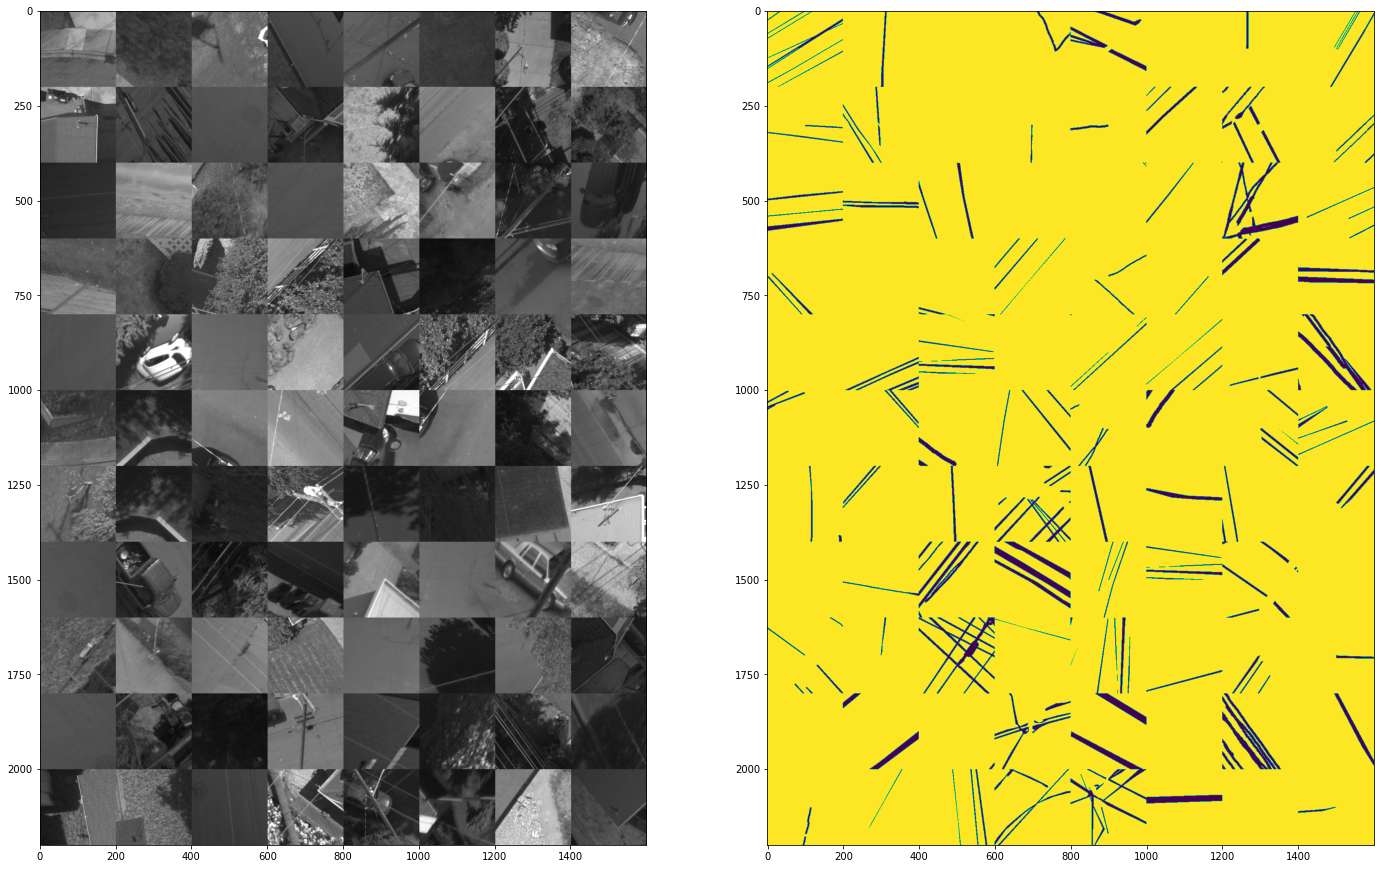

In [ ]:
plt.figure(figsize=(50,50))
# print(np.where(mask==1,1,0).sum())
plt.subplot(1,4,1)
plt.imshow(img_final.astype('uint8'))
plt.subplot(1,4,2)
plt.imshow(np.where(mask_final==8, 0,1))

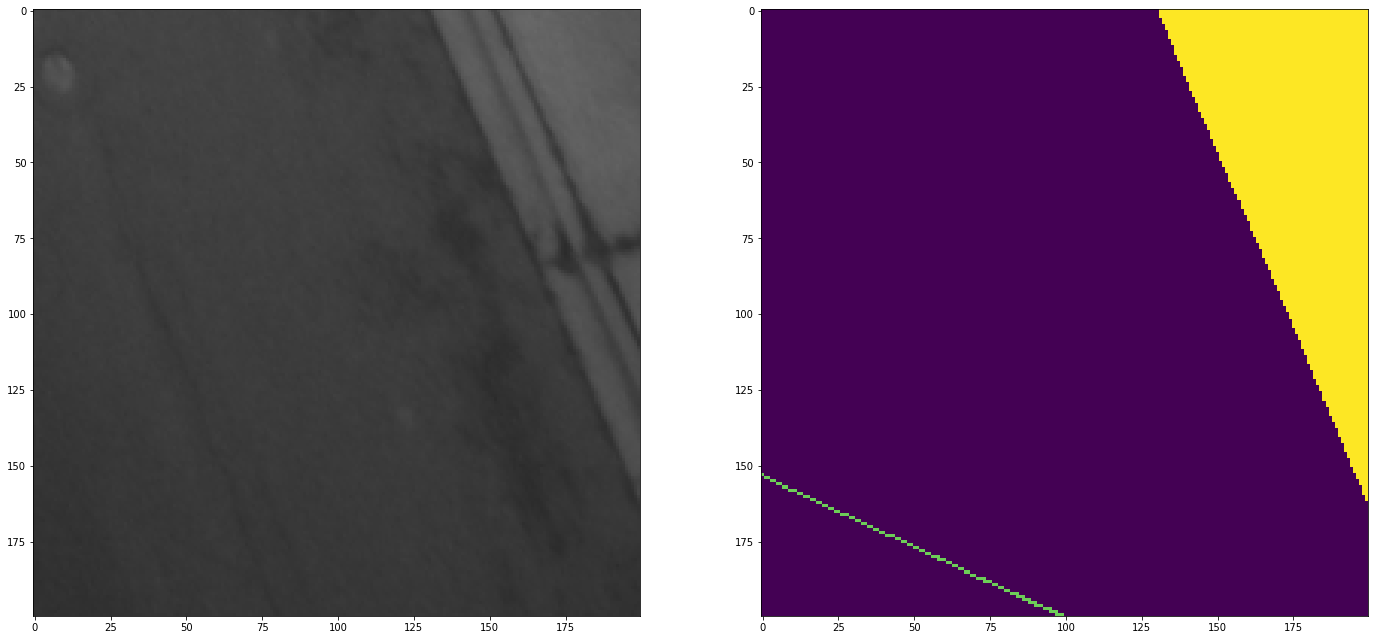

In [ ]:
plt.figure(figsize=(50,50))
# print(np.where(mask==1,1,0).sum())
plt.subplot(1,4,1)
plt.imshow(img_pos)
plt.subplot(1,4,2)
plt.imshow(msk_pos)

In [ ]:
soil_images = [
    'ffa00bc2e87d4c3a85ce2ef5527b34b8-1632162022000003268.png',
'fdf84a60d8a7441c8ab130a7ec4bf78d-1617729163700006136.png',
'fdf84a60d8a7441c8ab130a7ec4bf78d-1617729155500005981.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593181600003709.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593168200003439.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593159200003256.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593157000003203.png',
'fda5cf55f0d243c2bc1ce27fa3cc4887-1634593153600003135.png',
'fc826f0980244d0893e0e4a30fc4b03a-1620683456200002531.png',
'fc4c7367a1784219be46a733ba33fcf1-1621975791500010454.png',
'fc4c7367a1784219be46a733ba33fcf1-1621975788400010399.png',
'fc4c7367a1784219be46a733ba33fcf1-1621975783600010310.png',
'fa2f40d005e04f6d8b2d8946211a3b5c-1624550757100004381.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145180500004963.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145174700004856.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145171300004778.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145165500004668.png',
'f9fae46e09b14bd0b5d45ea2d7109d5e-1620145160400004558.png',
'f7d74954c6b74475b601bb8af1ce00d1-1632243667500002909.png',
'f7128caf7caf436b8aacf94255bf0393-1618422537600006394.png',
'f7128caf7caf436b8aacf94255bf0393-1618422532400006295.png',
'f7128caf7caf436b8aacf94255bf0393-1618422529700006252.png',
'f7128caf7caf436b8aacf94255bf0393-1618422525000006136.png',
'f7128caf7caf436b8aacf94255bf0393-1618422523400006117.png',
'f6d208ab107b425bae6f41f75bbe8f59-1632342829100003932.png',
'f6d208ab107b425bae6f41f75bbe8f59-1632342825900003865.png',
'f6d208ab107b425bae6f41f75bbe8f59-1632342821000003765.png',
'f6d208ab107b425bae6f41f75bbe8f59-1632342816900003680.png',
'f5f3bbe3981e4046b1d3abd2f8d5d1d0-1623092207000014594.png',
'f5f3bbe3981e4046b1d3abd2f8d5d1d0-1623092202800014508.png',
'f5f3bbe3981e4046b1d3abd2f8d5d1d0-1623092200700014479.png',
'f5f3bbe3981e4046b1d3abd2f8d5d1d0-1623092193700014326.png',
'f5c241d1222e434e8e4e1407fb6701b6-1617728486100002929.png',
'f5c241d1222e434e8e4e1407fb6701b6-1617728481800002842.png',
'f5c241d1222e434e8e4e1407fb6701b6-1617728478100002771.png',
'f5c241d1222e434e8e4e1407fb6701b6-1617728474500002709.png',
'f52162f51f4344fba442c0ac968ea347-1631290478000010608.png',
'f52162f51f4344fba442c0ac968ea347-1631290472700010497.png',
'f52162f51f4344fba442c0ac968ea347-1631290468800010402.png',
'f52162f51f4344fba442c0ac968ea347-1631290466100010353.png',
'f403099d20bf4899a70ab0d817ad0d7b-1619540318800001743.png',
'f403099d20bf4899a70ab0d817ad0d7b-1619540315100001678.png',
'f3ab6afd33a54a35982f97d80293d830-1626297958600006427.png',
'f3ab6afd33a54a35982f97d80293d830-1626297948500006212.png',
'f3ab6afd33a54a35982f97d80293d830-1626297938300006007.png',
'f316ba069d1f4ef48a34c36839b6f31c-1621445726400021949.png',
'f316ba069d1f4ef48a34c36839b6f31c-1621445717900021773.png',
'f316ba069d1f4ef48a34c36839b6f31c-1621445712200021658.png',
'f316ba069d1f4ef48a34c36839b6f31c-1621445708600021585.png',
'f2cbf871c46041978020f4d49e0eceb1-1618945790300004301.png',
'f2cbf871c46041978020f4d49e0eceb1-1618945787900004242.png',
'f2cbf871c46041978020f4d49e0eceb1-1618945785000004201.png',
'f0d7eaf3629840149054be131dfb33f6-1620769359700005699.png',
'f0d7eaf3629840149054be131dfb33f6-1620769358200005676.png',
'eff3c43f50074dc280d6c14e0cb1ab26-1621976414600007268.png',
'eff3c43f50074dc280d6c14e0cb1ab26-1621976408100007127.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810020300013169.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810017000013096.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810014400013047.png',
'ee655b7463ae41968ac609a6d1a7b0cb-1614810009700012934.png',
'edf4feea97b84a9aa58671038a8ffd6d-1617730216800005840.png',
'edf4feea97b84a9aa58671038a8ffd6d-1617730205000005610.png',
'edf4feea97b84a9aa58671038a8ffd6d-1617730201100005535.png',
'edf4feea97b84a9aa58671038a8ffd6d-1617730193300005364.png',
'ed4a3859216a48db8b6d04eed5aacdc5-1618343942200005654.png',
'eb97dfc011104c9d93567af8caf150f8-1622050320900026271.png',
'eb97dfc011104c9d93567af8caf150f8-1622050319600026236.png',
'eb97dfc011104c9d93567af8caf150f8-1622050314000026118.png',
'eb97dfc011104c9d93567af8caf150f8-1622050311500026070.png',
'eb97dfc011104c9d93567af8caf150f8-1622050305900025964.png',
'eb3fe9c440ab4e9389a3f689d7bd92f0-1617730832800005166.png',
'eb3fe9c440ab4e9389a3f689d7bd92f0-1617730816600004842.png',
'eb3fe9c440ab4e9389a3f689d7bd92f0-1617730797400004450.png',
'eb3fe9c440ab4e9389a3f689d7bd92f0-1617730793000004367.png',
'eb3fe9c440ab4e9389a3f689d7bd92f0-1617730791500004351.png',
'eb01a7dc44974dda82a7e091deac1a3f-1620770011900005814.png',
'eb01a7dc44974dda82a7e091deac1a3f-1620770010100005779.png',
'eb01a7dc44974dda82a7e091deac1a3f-1620770006500005699.png',
'ead7e12e0caf485fbaa0f14d93985ea1-1619035302800002186.png',
'ea1f385224644c9bb1ca1f7e00deffce-1620143346100020061.png',
'ea1f385224644c9bb1ca1f7e00deffce-1620143327300019696.png',
'e96b49a584a040209fc4e0b9ba7cbb3f-1621370702700011055.png',
'e96b49a584a040209fc4e0b9ba7cbb3f-1621370699700011011.png',
'e96b49a584a040209fc4e0b9ba7cbb3f-1621370692100010852.png',
'e7bc31f0df12478c9a01d5cfb2407ce4-1619027841700005254.png',
'e7bc31f0df12478c9a01d5cfb2407ce4-1619027838500005172.png',
'e7bc31f0df12478c9a01d5cfb2407ce4-1619027832000005061.png',
'e7bc31f0df12478c9a01d5cfb2407ce4-1619027823900004892.png',
'e6d7db99b4714c478df0187bc99b3e47-1624393587500010412.png',
'e6d7db99b4714c478df0187bc99b3e47-1624393573600010132.png',
'e6d7db99b4714c478df0187bc99b3e47-1624393562200009923.png',
'e6d7db99b4714c478df0187bc99b3e47-1624393558500009841.png',
'e67f53b87b724bc894b633e8498a4c53-1619119265500006578.png',
'e67f53b87b724bc894b633e8498a4c53-1619119263200006543.png',
'e67f53b87b724bc894b633e8498a4c53-1619119260900006477.png',
'e67f53b87b724bc894b633e8498a4c53-1619119252300006320.png',
'e621402591c0488ca315279736e26396-1619111219400002869.png',
'e621402591c0488ca315279736e26396-1619111214300002753.png',
'e621402591c0488ca315279736e26396-1619111209900002674.png',
'e621402591c0488ca315279736e26396-1619111206700002611.png',
'e621402591c0488ca315279736e26396-1619111204200002569.png',
'e6099e59f93b445eb1a0b71c3e1fcab9-1621973317900004239.png',
'e6099e59f93b445eb1a0b71c3e1fcab9-1621973273500003362.png',
'e6099e59f93b445eb1a0b71c3e1fcab9-1621973255200002993.png',
'e575bb1a59864b068520989d2d925421-1617210887200003324.png',
'e575bb1a59864b068520989d2d925421-1617210881000003192.png',
'e575bb1a59864b068520989d2d925421-1617210871000002999.png',
'e575bb1a59864b068520989d2d925421-1617210868700002957.png',
'e560e2abf4a741978ea9f92d1dc1db3a-1624392698500008909.png',
'e560e2abf4a741978ea9f92d1dc1db3a-1624392697200008901.png',
'e560e2abf4a741978ea9f92d1dc1db3a-1624392691700008781.png',
'e560e2abf4a741978ea9f92d1dc1db3a-1624392687300008707.png',
'e560e2abf4a741978ea9f92d1dc1db3a-1624392684200008626.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241949200003787.png',
'e42d51d5071540babbd4b49be3c15ad6-1657241945000003707.png',
'e429282023f246818ca8298a9febd770-1621277857200015286.png',
'e2b0820096dc495ebd29f3b8c44886d9-1618255738800003847.png',
'e2b0820096dc495ebd29f3b8c44886d9-1618255732000003724.png',
'e2b0820096dc495ebd29f3b8c44886d9-1618255725100003575.png',
'e2b0820096dc495ebd29f3b8c44886d9-1618255723200003542.png',
'e25f17a327004f8988b168e9c7ddd52c-1619038563500008344.png',
'e25f17a327004f8988b168e9c7ddd52c-1619038559100008262.png',
'e1c678a8cd6d483596798ad0bdb79ce3-1620150136000004634.png',
'e1c678a8cd6d483596798ad0bdb79ce3-1620150113000004176.png',
'e1c678a8cd6d483596798ad0bdb79ce3-1620150109500004089.png',
'e1c678a8cd6d483596798ad0bdb79ce3-1620150102400003966.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446498400013508.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446471300012967.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446454500012653.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446448300012506.png',
'e1a5d6fd614b4c2abe116884235ecad8-1621446444100012422.png',
'e02ed09b04df4b29a42389fecd40d3e9-1619648569200008223.png',
'e02ed09b04df4b29a42389fecd40d3e9-1619648563500008109.png',
'e02ed09b04df4b29a42389fecd40d3e9-1619648558500008008.png',
'e02ed09b04df4b29a42389fecd40d3e9-1619648554200007913.png',
'e02ed09b04df4b29a42389fecd40d3e9-1619648553500007910.png',
'ded7816c2be44b4eb7d06e2b62e520e2-1619024798900010497.png',
'ded7816c2be44b4eb7d06e2b62e520e2-1619024782500010164.png',
'dd6b19911f1843d695fe490b2b7e60b0-1631484391100003788.png',
'dba186fd73e3488789d8326fbd4d9f44-1617210340200002937.png',
'dba186fd73e3488789d8326fbd4d9f44-1617210336800002864.png',
'dba186fd73e3488789d8326fbd4d9f44-1617210333500002792.png',
'dba186fd73e3488789d8326fbd4d9f44-1617210329600002709.png',
'dba186fd73e3488789d8326fbd4d9f44-1617210326200002666.png',
'db86f9a4c2fd4e60bcf24b057d08c305-1621364852900015520.png',
'db86f9a4c2fd4e60bcf24b057d08c305-1621364846000015385.png',
'db86f9a4c2fd4e60bcf24b057d08c305-1621364836400015192.png',
'db7a193641734182aab1789f6fd51490-1628196614700001554.png',
'db7a193641734182aab1789f6fd51490-1628196611900001497.png',
'db7a193641734182aab1789f6fd51490-1628196609000001457.png',
'db7a193641734182aab1789f6fd51490-1628196603300001333.png',
'db6cd2cace324e38b4188622d6b3e91a-1619717550200019684.png',
'db6cd2cace324e38b4188622d6b3e91a-1619717549500019680.png',
'db6cd2cace324e38b4188622d6b3e91a-1619717542000019520.png',
'db6cd2cace324e38b4188622d6b3e91a-1619717537600019433.png',
'db6cd2cace324e38b4188622d6b3e91a-1619717535300019384.png',
'dacada20c4504b7f8a2f7ffbb4007fd0-1619026571700004237.png',
'da7d9f7e9c014b74b01e70252c9322f2-1643928307400016302.png',
'da7d9f7e9c014b74b01e70252c9322f2-1643928304400016235.png',
'da7d9f7e9c014b74b01e70252c9322f2-1643928302200016205.png',
'da7d9f7e9c014b74b01e70252c9322f2-1643928296900016102.png',
'da4cc49f4507413981793b8479abd873-1628011292100006664.png',
'da4cc49f4507413981793b8479abd873-1628011288000006588.png',
'da4cc49f4507413981793b8479abd873-1628011285300006548.png',
'da4cc49f4507413981793b8479abd873-1628011281100006464.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619305100021432.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619303500021397.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619300000021325.png',
'd9f11224a93543dead4cbb1ea3a6ce84-1654619297300021273.png',
'd84d732bc31345dc8d778ba6417a90af-1627596028300004485.png',
'd84d732bc31345dc8d778ba6417a90af-1627596026000004417.png',
'd7bf309a43af485d9ba6e80598407468-1621891254300015829.png',
'd7bf309a43af485d9ba6e80598407468-1621891247800015716.png',
'd7bf309a43af485d9ba6e80598407468-1621891244100015628.png',
'd7bf309a43af485d9ba6e80598407468-1621891239100015531.png',
'd7bf309a43af485d9ba6e80598407468-1621891235400015461.png',
'd7733b8a7de6420ea64c19b9349089d7-1623776016100004028.png',
'd741f36bede9409bb26a080d829ce28d-1626196911700003355.png',
'd741f36bede9409bb26a080d829ce28d-1626196907000003260.png',
'd741f36bede9409bb26a080d829ce28d-1626196900700003142.png',
'd741f36bede9409bb26a080d829ce28d-1626196898300003104.png',
'd741f36bede9409bb26a080d829ce28d-1626196891200002962.png',
'd71c42c2da144768b1c84247f856641a-1617818102600005321.png',
'd71c42c2da144768b1c84247f856641a-1617818098900005257.png',
'd71c42c2da144768b1c84247f856641a-1617818096700005217.png',
'd4399b6873b648898f06db70fa89c691-1619027083300003889.png',
'd4399b6873b648898f06db70fa89c691-1619027077500003769.png',
'd4399b6873b648898f06db70fa89c691-1619027068100003581.png',
'd4399b6873b648898f06db70fa89c691-1619027064400003527.png',
'd3c7addb66904937a17a4cf5649b2247-1660187639300001334.png',
'd3c7addb66904937a17a4cf5649b2247-1660187632900001212.png',
'd3c7addb66904937a17a4cf5649b2247-1660187630300001160.png',
'd3c7addb66904937a17a4cf5649b2247-1660187626500001093.png',
'd38dcf58f59142569e2f6b380ddecdc0-1655828535400016378.png',
'd38dcf58f59142569e2f6b380ddecdc0-1655828532200016327.png',
'd382c141fc804e1191c7256a6de7f1c9-1617729619700002134.png',
'd382c141fc804e1191c7256a6de7f1c9-1617729614100002021.png',
'd382c141fc804e1191c7256a6de7f1c9-1617729612200001987.png',
'd382c141fc804e1191c7256a6de7f1c9-1617729608500001912.png',
'd379bed59f30409bb088f571610183cb-1658289536400002020.png',
'd30438ad21d64a1c82fdb981165129a6-1618257293400005362.png',
'd30438ad21d64a1c82fdb981165129a6-1618257265100004789.png',
'd30438ad21d64a1c82fdb981165129a6-1618257260000004691.png',
'd30438ad21d64a1c82fdb981165129a6-1618257258700004651.png',
'd1f46f22e0f24546a4c1e84437034ed1-1629909411000004199.png',
'd1f46f22e0f24546a4c1e84437034ed1-1629909401400004006.png',
'd1f46f22e0f24546a4c1e84437034ed1-1629909367000003328.png',
'd1f46f22e0f24546a4c1e84437034ed1-1629909363200003263.png',
'd1c6c9d991c246aa99f266f4aa65caa7-1621446534100009845.png',
'd1c6c9d991c246aa99f266f4aa65caa7-1621446528500009732.png',
'd1c12a0f14ca4394a11b026a2df9396d-1631210465500002956.png',
'd1c12a0f14ca4394a11b026a2df9396d-1631210437900002415.png',
'd1c12a0f14ca4394a11b026a2df9396d-1631210427500002207.png',
'd1158187339b4068b191098195590cbb-1618942202400003710.png',
'd1158187339b4068b191098195590cbb-1618942178200003236.png',
'd1158187339b4068b191098195590cbb-1618942161500002906.png',
'd1158187339b4068b191098195590cbb-1618942156000002780.png',
'd1158187339b4068b191098195590cbb-1618942152300002719.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601731300006488.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601729900006435.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601725600006367.png',
'd0e8a2148d6f4263b66b4afbda56695e-1613601722800006312.png',
'd0e01bab875542a6953ada15d8c6a91b-1617306234000009618.png',
'd0e01bab875542a6953ada15d8c6a91b-1617306229100009525.png',
'd0e01bab875542a6953ada15d8c6a91b-1617306225900009455.png',
'd0e01bab875542a6953ada15d8c6a91b-1617306220200009344.png',
'd0e01bab875542a6953ada15d8c6a91b-1617306213700009224.png',
'd059fb725a984a8e8b088f9f12a2d6d3-1617658501800023736.png',
'd059fb725a984a8e8b088f9f12a2d6d3-1617658488300023453.png',
'd059fb725a984a8e8b088f9f12a2d6d3-1617658487600023431.png',
'd059fb725a984a8e8b088f9f12a2d6d3-1617658482900023339.png',
'cff650d368b943a18c6cfc6488c45a9d-1655828997700004590.png',
'cfea91984b604e76badebbea792f676a-1623361093600005234.png',
'cfea91984b604e76badebbea792f676a-1623361088000005117.png',
'cfea91984b604e76badebbea792f676a-1623361085100005077.png',
'cfea91984b604e76badebbea792f676a-1623361080200004960.png',
'cfea91984b604e76badebbea792f676a-1623361076000004902.png',
'ceb085229d744390825819837ae20708-1621280082500003683.png',
'ceb085229d744390825819837ae20708-1621280079500003632.png',
'ceb085229d744390825819837ae20708-1621280073500003502.png',
'ceb085229d744390825819837ae20708-1621280070500003447.png',
'ceb085229d744390825819837ae20708-1621280068100003396.png',
'cdea1eed27654f2f88fcaa98fb551bcb-1626128187900005612.png',
'cdea1eed27654f2f88fcaa98fb551bcb-1626128184600005548.png',
'cdea1eed27654f2f88fcaa98fb551bcb-1626128177900005417.png',
'cd4699fe5ea3431f9a8f2e5f6fcb6f69-1633627135100014935.png',
'cd4699fe5ea3431f9a8f2e5f6fcb6f69-1633627132200014873.png',
'cd4699fe5ea3431f9a8f2e5f6fcb6f69-1633627127100014784.png',
'cd4699fe5ea3431f9a8f2e5f6fcb6f69-1633627122000014666.png',
'cd4699fe5ea3431f9a8f2e5f6fcb6f69-1633627117700014589.png',
'cbe292d8482f436a81d8115a6711352f-1633627447200001030.png',
'ca5556d957ea434a88de0d8c6b9f40a9-1621974094000012405.png',
'ca5556d957ea434a88de0d8c6b9f40a9-1621974072500011952.png',
'ca5556d957ea434a88de0d8c6b9f40a9-1621974058100011675.png',
'ca17c81d845b48f48097b30db1ddbd37-1634665879600002188.png',
'c950ca48417b45978580d22f4e980b1d-1629563393500002323.png',
'c7982cacf0a94c739443a819da0e33e8-1617729690300015483.png',
'c7982cacf0a94c739443a819da0e33e8-1617729685600015380.png',
'c7982cacf0a94c739443a819da0e33e8-1617729682200015303.png',
'c651c9132c994487804ef4c74d3ef4db-1618944327800005806.png',
'c651c9132c994487804ef4c74d3ef4db-1618944325400005771.png',
'c651c9132c994487804ef4c74d3ef4db-1618944321200005672.png',
'c64d4545ccee49f6958670ee2636b45a-1628195889700002069.png',
'c64d4545ccee49f6958670ee2636b45a-1628195885000001968.png',
'c64d4545ccee49f6958670ee2636b45a-1628195882300001910.png',
'c64d4545ccee49f6958670ee2636b45a-1628195877500001811.png',
'c5e91d1c1cc44fbaae28a48146de3824-1619036086700002854.png',
'c5b7c8e267ee43128518441be69151da-1621974641600003873.png',
'c5b7c8e267ee43128518441be69151da-1621974635500003733.png',
'c5b7c8e267ee43128518441be69151da-1621974631400003665.png',
'c42fac0cf3e34db28ec914d134379255-1624900241100002273.png',
'c42fac0cf3e34db28ec914d134379255-1624900236700002180.png',
'c42fac0cf3e34db28ec914d134379255-1624900235900002179.png',
'c3a116194899455c90726103910f2540-1631204440200006128.png',
'c3a116194899455c90726103910f2540-1631204431200005945.png',
'c3a116194899455c90726103910f2540-1631204411800005550.png',
'c3a116194899455c90726103910f2540-1631204407300005462.png',
'c388e1394f6f4380a97b789a83782994-1620144549600004571.png',
'c388e1394f6f4380a97b789a83782994-1620144504700003676.png',
'c388e1394f6f4380a97b789a83782994-1620144476600003114.png',
'c388e1394f6f4380a97b789a83782994-1620144473800003035.png',
'c320bd182af84adcb2805aae192b1708-1615924556900008564.png',
'c320bd182af84adcb2805aae192b1708-1615924550700008452.png',
'c320bd182af84adcb2805aae192b1708-1615924546800008374.png',
'c320bd182af84adcb2805aae192b1708-1615924545300008347.png',
'c3133131eabb43cfa60451451ef817e1-1652805499300004914.png',
'c3133131eabb43cfa60451451ef817e1-1652805480700004558.png',
'c3133131eabb43cfa60451451ef817e1-1652805477900004505.png',
'c3133131eabb43cfa60451451ef817e1-1652805476400004455.png',
'c2b7fd9388f44060848d85db7f12d9b5-1621448452200003913.png',
'c2b7fd9388f44060848d85db7f12d9b5-1621448443000003718.png',
'c2b7fd9388f44060848d85db7f12d9b5-1621448439200003665.png',
'c25de20505b84e859fbb961e03b4887f-1617215186900005438.png',
'c15e03dec6804ce1b3d77e2c22290c5c-1615331923400007191.png',
'c15e03dec6804ce1b3d77e2c22290c5c-1615331916700007058.png',
'c15e03dec6804ce1b3d77e2c22290c5c-1615331913700006993.png',
'c15e03dec6804ce1b3d77e2c22290c5c-1615331910000006933.png',
'c15e03dec6804ce1b3d77e2c22290c5c-1615331903200006805.png',
'bf1925dff2f942b1a3d01462661be818-1632161489100007586.png',
'bf1925dff2f942b1a3d01462661be818-1632161474900007313.png',
'bf1925dff2f942b1a3d01462661be818-1632161453500006885.png',
'bf1925dff2f942b1a3d01462661be818-1632161446400006729.png',
'bf1925dff2f942b1a3d01462661be818-1632161439300006590.png',
'bc0d101a71434c8795f381c1ada8e1e1-1620064845800010723.png',
'bc0d101a71434c8795f381c1ada8e1e1-1620064833300010490.png',
'bc0d101a71434c8795f381c1ada8e1e1-1620064814600010105.png',
'bc0d101a71434c8795f381c1ada8e1e1-1620064808400009979.png',
'bb7f7ca7636d45e9a8cebf3894a0e101-1626195038600005396.png',
'bb7f7ca7636d45e9a8cebf3894a0e101-1626195035200005341.png',
'bb7f7ca7636d45e9a8cebf3894a0e101-1626195032300005282.png',
'bb7f7ca7636d45e9a8cebf3894a0e101-1626195028900005210.png',
'bb7f7ca7636d45e9a8cebf3894a0e101-1626195025500005145.png',
'bb77c46dc5e34f55a6169bc6d1d37f0d-1624556124600051477.png',
'bb77c46dc5e34f55a6169bc6d1d37f0d-1624556122800051445.png',
'bb77c46dc5e34f55a6169bc6d1d37f0d-1624556118200051366.png',
'bb77c46dc5e34f55a6169bc6d1d37f0d-1624556114800051284.png',
'baf8c858f5454b33b2cf422bcc5d9827-1622051604600004086.png',
'baf8c858f5454b33b2cf422bcc5d9827-1622051566200003313.png',
'baf8c858f5454b33b2cf422bcc5d9827-1622051560400003203.png',
'baf8c858f5454b33b2cf422bcc5d9827-1622051556600003133.png',
'baf8c858f5454b33b2cf422bcc5d9827-1622051550800003000.png',
'babf433a48ce4e05a470b698ba596c74-1618260518000004620.png',
'babf433a48ce4e05a470b698ba596c74-1618260469700003669.png',
'b9ef87989f654dec8e9a898af819f8dc-1622059552600008834.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404971200007564.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404968400007508.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404963800007435.png',
'b9113f0a301a45f9a07c617f9696e6c6-1627404962600007403.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280567700004834.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280567100004826.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280560700004700.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280556200004605.png',
'b79e3c6310574145b1ccc5dddb4502f1-1621280555500004594.png',
'b4556c0520b9486294ba24edb26be619-1630862709000003575.png',
'b4556c0520b9486294ba24edb26be619-1630862707700003538.png',
'b4556c0520b9486294ba24edb26be619-1630862703700003462.png',
'b4556c0520b9486294ba24edb26be619-1630862699100003370.png',
'b3b6aadfef4045b8881c7e9ef8550b9c-1612482229900005327.png',
'b3b6aadfef4045b8881c7e9ef8550b9c-1612482204700004838.png',
'b3b6aadfef4045b8881c7e9ef8550b9c-1612482197300004670.png',
'b3b6aadfef4045b8881c7e9ef8550b9c-1612482191400004553.png',
'b3b6aadfef4045b8881c7e9ef8550b9c-1612482189900004521.png',
'b219a4fc4d554ccd8d38b9d12d8a3eb6-1621447106900003453.png',
'b0fc8b368dfa446f826f76e32dfa6a28-1619110083800004729.png',
'b0fc8b368dfa446f826f76e32dfa6a28-1619110082600004694.png',
'b0fc8b368dfa446f826f76e32dfa6a28-1619110076500004575.png',
'b0fc8b368dfa446f826f76e32dfa6a28-1619110072800004505.png',
'b0fc8b368dfa446f826f76e32dfa6a28-1619110071600004469.png',
'aebae6ef758540f28814cc34e43b1952-1619035678800002304.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875590600017423.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875584400017296.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875580500017228.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875575100017125.png',
'ae2f0301235c41bfb13fb3e9faa4d798-1621875569700017007.png',
'ad3b5f6a9893494682d1c560779837b7-1623259406300005327.png',
'ad3b5f6a9893494682d1c560779837b7-1623259376100004717.png',
'ad3b5f6a9893494682d1c560779837b7-1623259374400004673.png',
'ac94b46280c34fcbbf23d3656ac00b44-1644530949600006699.png',
'ac94b46280c34fcbbf23d3656ac00b44-1644530945900006622.png',
'ac879c892f4c4e5b88301fbf85494b23-1632242593900003323.png',
'ac879c892f4c4e5b88301fbf85494b23-1632242593300003315.png',
'ac879c892f4c4e5b88301fbf85494b23-1632242588900003232.png',
'ab7d7eaa81f14841bf8e632c01550924-1619025854700003148.png',
'ab7d7eaa81f14841bf8e632c01550924-1619025825700002560.png',
'ab7d7eaa81f14841bf8e632c01550924-1619025822200002488.png',
'ab7d7eaa81f14841bf8e632c01550924-1619025815400002361.png',
'aa31bff74bec453ea28f27b7e17b1477-1658289895700001574.png',
'aa26382e632a49da823446059ce7412d-1622569657400013189.png',
'aa26382e632a49da823446059ce7412d-1622569650700013040.png',
'aa26382e632a49da823446059ce7412d-1622569647600012982.png',
'aa26382e632a49da823446059ce7412d-1622569642100012875.png',
'a65d20d4d98f4d4bad3f395a2c5fcc87-1615327889500008037.png',
'a65d20d4d98f4d4bad3f395a2c5fcc87-1615327884000007941.png',
'a65d20d4d98f4d4bad3f395a2c5fcc87-1615327880600007875.png',
'a65d20d4d98f4d4bad3f395a2c5fcc87-1615327877900007821.png',
'a65d20d4d98f4d4bad3f395a2c5fcc87-1615327872400007688.png',
'a5a83de959aa433a8b5b2d258804bc1c-1616704585800004130.png',
'a5a83de959aa433a8b5b2d258804bc1c-1616704573200003868.png',
'a5a83de959aa433a8b5b2d258804bc1c-1616704551200003426.png',
'a5a83de959aa433a8b5b2d258804bc1c-1616704544900003305.png',
'a5a83de959aa433a8b5b2d258804bc1c-1616704541800003254.png',
'a531270d23a04a9eb9ae91d1be14b81d-1617729610100016341.png',
'a531270d23a04a9eb9ae91d1be14b81d-1617729603800016218.png',
'a531270d23a04a9eb9ae91d1be14b81d-1617729601000016150.png',
'a531270d23a04a9eb9ae91d1be14b81d-1617729597600016091.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941671000006183.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941619700005142.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941617400005091.png',
'a4dc322c09d3401aa7fcc1007fc1d867-1618941608500004918.png',
'a4bfadd15cca4a63b06af68b7656bace-1619647749000005459.png',
'a4bfadd15cca4a63b06af68b7656bace-1619647741300005316.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445449400005830.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445443200005688.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445440000005625.png',
'a340eaa5cece4f49ad275f67bc160f2c-1621445433800005509.png',
'a24e48c94a8e4912b0094be98f7517c4-1619107938100016783.png',
'a24e48c94a8e4912b0094be98f7517c4-1619107935300016732.png',
'a24e48c94a8e4912b0094be98f7517c4-1619107931100016656.png',
'a24e48c94a8e4912b0094be98f7517c4-1619107926900016575.png',
'a219be9df80b4431bd952700b840262f-1622742019000010668.png',
'a219be9df80b4431bd952700b840262f-1622741999200010280.png',
'a219be9df80b4431bd952700b840262f-1622741984300009986.png',
'a219be9df80b4431bd952700b840262f-1622741977700009856.png',
'a1cdb67568124e548a7c3ed0b0b9ce2e-1621447852300005596.png',
'a1cdb67568124e548a7c3ed0b0b9ce2e-1621447847300005501.png',
'9fa0676490b744c1b04f205704f91d43-1614811742700009922.png',
'9fa0676490b744c1b04f205704f91d43-1614811730000009669.png',
'9f9eb69cd0994981bd03bae31f2b4d6c-1618941027700011539.png',
'9f9eb69cd0994981bd03bae31f2b4d6c-1618941019800011388.png',
'9f9eb69cd0994981bd03bae31f2b4d6c-1618941016500011325.png',
'9f9eb69cd0994981bd03bae31f2b4d6c-1618941012000011224.png',
'9e179fcf5ca74ea0a7905c03ca86b8ad-1643928768900004298.png',
'9e179fcf5ca74ea0a7905c03ca86b8ad-1643928767800004269.png',
'9e179fcf5ca74ea0a7905c03ca86b8ad-1643928765700004226.png',
'9db5dd4832df40cab0cb3126bd617be5-1626298636100006417.png',
'9bdd4e00dad44d388cc6150eed7dbd9a-1617743499700003768.png',
'9b5d64b124404976910296c14616b457-1654620549400010237.png',
'9b5d64b124404976910296c14616b457-1654620544400010147.png',
'9b5d64b124404976910296c14616b457-1654620516900009588.png',
'9b5d64b124404976910296c14616b457-1654620515600009557.png',
'9b5d64b124404976910296c14616b457-1654620513100009522.png',
'9b345ff8cfca44bf946a3a45bd13204e-1623178462600003713.png',
'9b345ff8cfca44bf946a3a45bd13204e-1623178456500003592.png',
'9a71d82b827e4fd6acad4d6137391447-1619645309300009416.png',
'98fdd7d3fe50494583aa81092e5a08da-1631204780100002098.png',
'98daa55e493646488defa00b4b7c097c-1617919913400007152.png',
'98daa55e493646488defa00b4b7c097c-1617919909600007073.png',
'98daa55e493646488defa00b4b7c097c-1617919905800006996.png',
'98daa55e493646488defa00b4b7c097c-1617919899500006850.png',
'9870a475e7934cc6bc85aea6bdf80d93-1625162711000005586.png',
'9786cc0a190b4b7483615a69a884c3c6-1618265134100006121.png',
'9786cc0a190b4b7483615a69a884c3c6-1618265124500005930.png',
'9786cc0a190b4b7483615a69a884c3c6-1618265120700005842.png',
'9786cc0a190b4b7483615a69a884c3c6-1618265116900005779.png',
'96fe8f9225c2416da801083de8b266ad-1618343217300009511.png',
'96fe8f9225c2416da801083de8b266ad-1618343215100009479.png',
'95be161966dc4ccf90ba1efbe1cb65a5-1619547417300010969.png',
'95be161966dc4ccf90ba1efbe1cb65a5-1619547415000010938.png',
'95be161966dc4ccf90ba1efbe1cb65a5-1619547412100010886.png',
'942da0d4735f4dbeb80d7f03daf4e437-1621876245000005192.png',
'9413b2cc11ff40a49c68be94b9148bd6-1606950964800005774.png',
'9413b2cc11ff40a49c68be94b9148bd6-1606950924100004954.png',
'9413b2cc11ff40a49c68be94b9148bd6-1606950901300004499.png',
'9413b2cc11ff40a49c68be94b9148bd6-1606950896200004414.png',
'9413b2cc11ff40a49c68be94b9148bd6-1606950893600004361.png',
'93eba22e5f174c2e9aa64d335fa3c5e2-1620771575000002507.png',
'93eba22e5f174c2e9aa64d335fa3c5e2-1620771573200002488.png',
'93eba22e5f174c2e9aa64d335fa3c5e2-1620771564100002294.png',
'93807df84a824cdc9127a5b3674cd630-1630863030600001597.png',
'93807df84a824cdc9127a5b3674cd630-1630863024500001493.png',
'93807df84a824cdc9127a5b3674cd630-1630863022500001452.png',
'93807df84a824cdc9127a5b3674cd630-1630863018400001375.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596617700009854.png',
'934e55d3b4714ed7ba3d0716b534b5a1-1613596615000009814.png',
'922d0df2aa8d4288b280674eb80d8e38-1623367063300005355.png',
'922d0df2aa8d4288b280674eb80d8e38-1623367052200005145.png',
'91f219c5e5314cdc987b06d305ff884a-1613597225600004163.png',
'91f219c5e5314cdc987b06d305ff884a-1613597223400004118.png',
'91f219c5e5314cdc987b06d305ff884a-1613597216400003981.png',
'91f219c5e5314cdc987b06d305ff884a-1613597214200003935.png',
'906e54ead2bd4550822ceac614140c97-1629662358400012231.png',
'906e54ead2bd4550822ceac614140c97-1629662345200011986.png',
'906e54ead2bd4550822ceac614140c97-1629662344000011941.png',
'906e54ead2bd4550822ceac614140c97-1629662338000011836.png',
'9058daa0f612450ab4901ccdf39512b8-1623177954800009333.png',
'9058daa0f612450ab4901ccdf39512b8-1623177903800008332.png',
'9058daa0f612450ab4901ccdf39512b8-1623177899600008232.png',
'9058daa0f612450ab4901ccdf39512b8-1623177895300008152.png',
'90157d8c90b44497b10c8f34f8d9ab29-1618942369300023808.png',
'90157d8c90b44497b10c8f34f8d9ab29-1618942364200023697.png',
'90157d8c90b44497b10c8f34f8d9ab29-1618942361600023650.png',
'8ff7cee09e634122a0116ae9d587332e-1624899789100015315.png',
'8ff7cee09e634122a0116ae9d587332e-1624899784600015230.png',
'8ff7cee09e634122a0116ae9d587332e-1624899781600015175.png',
'8ff7cee09e634122a0116ae9d587332e-1624899775500015030.png',
'8e415c8c83a244ffa3535ab547c144cc-1616705162100004798.png',
'8e415c8c83a244ffa3535ab547c144cc-1616705144800004437.png',
'8e415c8c83a244ffa3535ab547c144cc-1616705122200004003.png',
'8e415c8c83a244ffa3535ab547c144cc-1616705118800003924.png',
'8de58b4322f74c0183ab633b8aefd0b6-1658374321700002075.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278960500002777.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278943000002430.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278940100002364.png',
'8d0b987dba1b41d1b1ffeee623337946-1621278935700002290.png',
'891d24c5cee840f3941a2bb9d7e46070-1622742610700005536.png',
'891d24c5cee840f3941a2bb9d7e46070-1622742582200004959.png',
'891d24c5cee840f3941a2bb9d7e46070-1622742568000004663.png',
'891d24c5cee840f3941a2bb9d7e46070-1622742564400004599.png',
'88f4cb1a58574f3d845a3faf9f7000bd-1620062315900019789.png',
'88f4cb1a58574f3d845a3faf9f7000bd-1620062310700019695.png',
'88f4cb1a58574f3d845a3faf9f7000bd-1620062306700019595.png',
'88aeb88e198e44a4b933ea3559ea80ec-1617727290200002567.png',
'88aeb88e198e44a4b933ea3559ea80ec-1617727285600002463.png',
'88aeb88e198e44a4b933ea3559ea80ec-1617727281600002395.png',
'88aeb88e198e44a4b933ea3559ea80ec-1617727278200002308.png',
'878b9d9af3354c00be657768d0e11a26-1621370573500023018.png',
'878b9d9af3354c00be657768d0e11a26-1621370571000022971.png',
'878b9d9af3354c00be657768d0e11a26-1621370567300022898.png',
'878b9d9af3354c00be657768d0e11a26-1621370561700022789.png',
'878b9d9af3354c00be657768d0e11a26-1621370560400022759.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278558500007660.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278544800007394.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278529700007073.png',
'87657a04c38c478fa99e4b86ff95ade1-1621278526900007023.png',
'872c27808cf14eb0bd37346eb4d7bc4f-1618856247600003815.png',
'872c27808cf14eb0bd37346eb4d7bc4f-1618856220900003287.png',
'804be9dcbfd1482e99725d423c10df9e-1618421859900005380.png',
'804be9dcbfd1482e99725d423c10df9e-1618421838300004954.png',
'804be9dcbfd1482e99725d423c10df9e-1618421834400004865.png',
'804be9dcbfd1482e99725d423c10df9e-1618421830500004799.png',
'7fe11e1aa96b42b7951f617db1bea549-1627595510300009807.png',
'7fe11e1aa96b42b7951f617db1bea549-1627595508900009762.png',
'7fe11e1aa96b42b7951f617db1bea549-1627595504800009681.png',
'7f24fcd40cd74f20ab33700bf3ab3ef1-1624558508800004018.png',
'7f24fcd40cd74f20ab33700bf3ab3ef1-1624558498600003795.png',
'7f24fcd40cd74f20ab33700bf3ab3ef1-1624558492500003678.png',
'7e268c3dba8941bdafb5802cf5fbd39c-1617817179800003243.png',
'7c772ac896984b6885ea3c86edebd8c4-1617900413200010278.png',
'7c772ac896984b6885ea3c86edebd8c4-1617900409100010199.png',
'7c772ac896984b6885ea3c86edebd8c4-1617900403800010079.png',
'7c772ac896984b6885ea3c86edebd8c4-1617900400800010017.png',
'7c772ac896984b6885ea3c86edebd8c4-1617900397300009958.png',
'7c2f8d6aaacb440aa01a8a7032901e85-1621285191900010388.png',
'7c2f8d6aaacb440aa01a8a7032901e85-1621285186600010295.png',
'7c2f8d6aaacb440aa01a8a7032901e85-1621285180400010147.png',
'7c2f8d6aaacb440aa01a8a7032901e85-1621285175800010079.png',
'7c2f8d6aaacb440aa01a8a7032901e85-1621285175100010055.png',
'7c271774b5d943038775112dc2dd7af8-1623362711000005986.png',
'7c271774b5d943038775112dc2dd7af8-1623362704600005857.png',
'7b4aa2259aa44a82b1d8e253f1167b06-1618352817600007308.png',
'7b4aa2259aa44a82b1d8e253f1167b06-1618352793400006822.png',
'7b4aa2259aa44a82b1d8e253f1167b06-1618352778200006515.png',
'792444f2973d41429fed6d157a736b17-1621891796300003124.png',
'792444f2973d41429fed6d157a736b17-1621891779500002802.png',
'792444f2973d41429fed6d157a736b17-1621891767900002561.png',
'792444f2973d41429fed6d157a736b17-1621891765300002508.png',
'792444f2973d41429fed6d157a736b17-1621891761400002436.png',
'7843cfcbb63648bf90ba79f67521adc7-1618248578900011711.png',
'782bab7c26c34eeeb108490b209c56a0-1619025259900002631.png',
'782bab7c26c34eeeb108490b209c56a0-1619025243400002297.png',
'782bab7c26c34eeeb108490b209c56a0-1619025238700002214.png',
'780c0807242849248970a0e3252fc3c4-1612397407600001676.png',
'77cd0ba0d82d4775b377e3e3f095fae0-1628011878800005740.png',
'77cd0ba0d82d4775b377e3e3f095fae0-1628011866300005500.png',
'77cd0ba0d82d4775b377e3e3f095fae0-1628011862800005438.png',
'77cd0ba0d82d4775b377e3e3f095fae0-1628011861000005388.png',
'7743e90f1205464696e4f72ac2f30108-1613586794800003873.png',
'7743e90f1205464696e4f72ac2f30108-1613586789700003760.png',
'7743e90f1205464696e4f72ac2f30108-1613586772800003423.png',
'766b8e722c5e47f195246e60ecde1bf6-1644861266900002313.png',
'766b8e722c5e47f195246e60ecde1bf6-1644861264100002259.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279574500004256.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279561400004007.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279548200003726.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279542400003621.png',
'748f7ecdd8434553a7a8d341eda4419e-1621279538000003535.png',
'7429a9c7b8d142899d668c958e7a8ef7-1619463647500002622.png',
'7429a9c7b8d142899d668c958e7a8ef7-1619463644900002582.png',
'73ab0297622f4cb5a954ec74618864f1-1629667803700004821.png',
'73ab0297622f4cb5a954ec74618864f1-1629667778900004329.png',
'73ab0297622f4cb5a954ec74618864f1-1629667773400004218.png',
'7307f27e44184a4b94fa7998383c68cc-1617816008900009251.png',
'729ad194108c4da4849f3f8dcb2f465e-1619470471500007664.png',
'729ad194108c4da4849f3f8dcb2f465e-1619470463200007491.png',
'729ad194108c4da4849f3f8dcb2f465e-1619470461100007455.png',
'7163d1e941434aba8d6edb1a4794c98d-1617912914100003518.png',
'7163d1e941434aba8d6edb1a4794c98d-1617912898100003202.png',
'7163d1e941434aba8d6edb1a4794c98d-1617912878800002800.png',
'7163d1e941434aba8d6edb1a4794c98d-1617912875600002737.png',
'7163d1e941434aba8d6edb1a4794c98d-1617912870800002635.png',
'6d8ed4d362f94d20a80a026f52a4f4fd-1660188021800002613.png',
'6d8ed4d362f94d20a80a026f52a4f4fd-1660188017200002507.png',
'6d5d99be78154507ba807e2844869f86-1612481569100004299.png',
'6d5d99be78154507ba807e2844869f86-1612481554900004007.png',
'6d5d99be78154507ba807e2844869f86-1612481552300003951.png',
'6d5d99be78154507ba807e2844869f86-1612481548400003887.png',
'6ce8414adf964ce6b129987571db3ba2-1621288168200050743.png',
'6ca5e034cad94fbda2d72b68b848d7e5-1618256193100003405.png',
'6ca5e034cad94fbda2d72b68b848d7e5-1618256187000003304.png',
'6ca5e034cad94fbda2d72b68b848d7e5-1618256184300003245.png',
'6ca5e034cad94fbda2d72b68b848d7e5-1618256178900003137.png',
'6ca5e034cad94fbda2d72b68b848d7e5-1618256175500003052.png',
'6c28c151db94488a91952108f23deaa8-1617811400800031884.png',
'6c28c151db94488a91952108f23deaa8-1617811397600031816.png',
'6c28c151db94488a91952108f23deaa8-1617811393600031752.png',
'6c28c151db94488a91952108f23deaa8-1617811389100031661.png',
'6ae31c29c6af45bcb30aa8d326284fcf-1658289193000011300.png',
'6734b86156ae4e26b39cb86be9d5edf7-1607635360100007516.png',
'6734b86156ae4e26b39cb86be9d5edf7-1607635354900007420.png',
'6734b86156ae4e26b39cb86be9d5edf7-1607635353800007404.png',
'66ae17b783914fb0af589118f7317f26-1617047421400005891.png',
'66ae17b783914fb0af589118f7317f26-1617047405400005565.png',
'66ae17b783914fb0af589118f7317f26-1617047393700005314.png',
'66ae17b783914fb0af589118f7317f26-1617047386400005176.png',
'65b472b814d947a28581ac1b10fb026c-1623774931300006029.png',
'65b472b814d947a28581ac1b10fb026c-1623774903000005469.png',
'65b472b814d947a28581ac1b10fb026c-1623774894900005310.png',
'65b472b814d947a28581ac1b10fb026c-1623774886800005156.png',
'64aef2ce8a1c438db0866641b19f2055-1617209470200004165.png',
'64aef2ce8a1c438db0866641b19f2055-1617209464100004039.png',
'62022db7d993471cb3086fad16ac54ff-1617046836400006483.png',
'62022db7d993471cb3086fad16ac54ff-1617046830800006356.png',
'62022db7d993471cb3086fad16ac54ff-1617046826000006261.png',
'62022db7d993471cb3086fad16ac54ff-1617046819700006144.png',
'62022db7d993471cb3086fad16ac54ff-1617046813300006003.png',
'610dbc85db4348d98da605a825be5d20-1626196477400004331.png',
'610dbc85db4348d98da605a825be5d20-1626196468400004161.png',
'610dbc85db4348d98da605a825be5d20-1626196463900004066.png',
'610dbc85db4348d98da605a825be5d20-1626196460100003987.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764371200006912.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764350300006497.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764345100006404.png',
'60e13aa1f2d04d8981f6c65b08e4dea7-1620764339900006292.png',
'5fd37f2e12a046d2aad076e622755e98-1622741165600024851.png',
'5fd37f2e12a046d2aad076e622755e98-1622741160000024740.png',
'5fd37f2e12a046d2aad076e622755e98-1622741158700024709.png',
'5fd37f2e12a046d2aad076e622755e98-1622741154400024617.png',
'5fd37f2e12a046d2aad076e622755e98-1622741151900024567.png',
'5f46d766632b4de4988a67a016ca2392-1617223884200013538.png',
'5f46d766632b4de4988a67a016ca2392-1617223882100013495.png',
'5f46d766632b4de4988a67a016ca2392-1617223879300013444.png',
'5f46d766632b4de4988a67a016ca2392-1617223875100013341.png',
'5ee5bfff18fd40d6944a70478645279b-1619645873600004691.png',
'5ee5bfff18fd40d6944a70478645279b-1619645855500004322.png',
'5ee5bfff18fd40d6944a70478645279b-1619645823700003686.png',
'5ee5bfff18fd40d6944a70478645279b-1619645816900003551.png',
'5ee5bfff18fd40d6944a70478645279b-1619645807800003356.png',
'5ebd54a6da60488b9549f3387041e8da-1617745622400010793.png',
'5ebd54a6da60488b9549f3387041e8da-1617745617800010691.png',
'5ebd54a6da60488b9549f3387041e8da-1617745614800010631.png',
'5ebd54a6da60488b9549f3387041e8da-1617745610300010550.png',
'5ebd54a6da60488b9549f3387041e8da-1617745602700010386.png',
'5e7dc890bfea45098a68ecf1c0daefbd-1624901052700005302.png',
'5e7dc890bfea45098a68ecf1c0daefbd-1624901047800005210.png',
'5e6a6ea21f5e498486acc453eb7bf756-1621371234600006907.png',
'5e6a6ea21f5e498486acc453eb7bf756-1621371215600006535.png',
'5e6a6ea21f5e498486acc453eb7bf756-1621371202400006253.png',
'5e6a6ea21f5e498486acc453eb7bf756-1621371196500006131.png',
'5e6a6ea21f5e498486acc453eb7bf756-1621371193600006082.png',
'5ddfb70f423c40c4971219be81dee26f-1631916452100004451.png',
'5ddfb70f423c40c4971219be81dee26f-1631916446300004345.png',
'5ddfb70f423c40c4971219be81dee26f-1631916443000004269.png',
'5ddfb70f423c40c4971219be81dee26f-1631916440500004233.png',
'5ddfb70f423c40c4971219be81dee26f-1631916433900004081.png',
'5dc617065cd84d67a99c4ca37a1fcc83-1617900970100003324.png',
'5dc617065cd84d67a99c4ca37a1fcc83-1617900965900003238.png',
'5dc617065cd84d67a99c4ca37a1fcc83-1617900960300003108.png',
'5dc617065cd84d67a99c4ca37a1fcc83-1617900958200003074.png',
'5dc617065cd84d67a99c4ca37a1fcc83-1617900951200002925.png',
'5d4656131e8d49f7ab9db2ad4de572d3-1617730221700003735.png',
'5bd8d91aec3d4485870539e87302ab2b-1617913666700004239.png',
'5bd8d91aec3d4485870539e87302ab2b-1617913662900004179.png',
'5bd8d91aec3d4485870539e87302ab2b-1617913657600004074.png',
'5bd8d91aec3d4485870539e87302ab2b-1617913650700003933.png',
'5bd8d91aec3d4485870539e87302ab2b-1617913648400003886.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359152000007641.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359150800007605.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359134700007300.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359122400007044.png',
'5bcf60c926e34fb3ad1c8fc935502261-1658359118700006983.png',
'5bcde0ccaef84b2692897574e4745b41-1622064978800004607.png',
'5bcde0ccaef84b2692897574e4745b41-1622064953800004112.png',
'5bcde0ccaef84b2692897574e4745b41-1622064930800003658.png',
'5bcde0ccaef84b2692897574e4745b41-1622064925000003538.png',
'5b6112c35a524fa4acedb076fb72feac-1617744803100004899.png',
'54b153c4c626433abaf22786b0f76266-1618259689800015101.png',
'54b153c4c626433abaf22786b0f76266-1618259686000015034.png',
'54b153c4c626433abaf22786b0f76266-1618259682900014982.png',
'54b153c4c626433abaf22786b0f76266-1618259679100014899.png',
'54ae0a04fd24424ab9b73f1a804dcaee-1624551256000003341.png',
'54ae0a04fd24424ab9b73f1a804dcaee-1624551245200003110.png',
'54ae0a04fd24424ab9b73f1a804dcaee-1624551234400002889.png',
'547ffbbc52af47189f49cd0f3b5e4bf6-1618256636100003535.png',
'547ffbbc52af47189f49cd0f3b5e4bf6-1618256633600003493.png',
'547ffbbc52af47189f49cd0f3b5e4bf6-1618256628000003379.png',
'547ffbbc52af47189f49cd0f3b5e4bf6-1618256624000003295.png',
'5404a5bcb2ee405db993861924803a3b-1618943532700001828.png',
'5404a5bcb2ee405db993861924803a3b-1618943528200001746.png',
'5404a5bcb2ee405db993861924803a3b-1618943521600001598.png',
'52224b3085674b8881aebbd585b21118-1643925480800008677.png',
'52224b3085674b8881aebbd585b21118-1643925475600008576.png',
'52224b3085674b8881aebbd585b21118-1643925474200008537.png',
'52224b3085674b8881aebbd585b21118-1643925471200008465.png',
'52224b3085674b8881aebbd585b21118-1643925469000008440.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444839100011413.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444836200011366.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444829700011214.png',
'518e97ff25b644baa2f6812f00f0a5ef-1621444827500011173.png',
'51433d0f4dda49239ce1a1de4ec291e0-1617816577400004671.png',
'50d640234030421f8bde2868d97b64bd-1618945009500005802.png',
'50d640234030421f8bde2868d97b64bd-1618945006900005753.png',
'503bbac676b54a3d861547d4ddec39f5-1634593514400002009.png',
'5039e0e97ac748e0b7c398bd84117a74-1606950316400014863.png',
'5039e0e97ac748e0b7c398bd84117a74-1606950288800014308.png',
'5039e0e97ac748e0b7c398bd84117a74-1606950265100013841.png',
'5039e0e97ac748e0b7c398bd84117a74-1606950261100013775.png',
'5035158b6a2d45fba5a7d905bd178d62-1616710045700009430.png',
'5035158b6a2d45fba5a7d905bd178d62-1616710033100009169.png',
'5035158b6a2d45fba5a7d905bd178d62-1616710030500009125.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876779900003194.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876767500002952.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876748000002539.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876737400002331.png',
'4f7026da0b67442ab52b039f3d0feddb-1621876733900002273.png',
'4e704628d4ef40cfb29b65496b513640-1637003808600007915.png',
'4e0f54ceb0b94d26a18dd3271ea8f3f1-1620065339600004928.png',
'4e0f54ceb0b94d26a18dd3271ea8f3f1-1620065334500004812.png',
'4e0f54ceb0b94d26a18dd3271ea8f3f1-1620065329300004719.png',
'4e0f54ceb0b94d26a18dd3271ea8f3f1-1620065327400004671.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915992100009082.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915989200009014.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915983800008901.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915982700008893.png',
'4d800030a38a4e5db5cbea801bb481e1-1631915979700008832.png',
'4c0f4f2c5b1346fe94e33471f6536bfe-1623092660900002340.png',
'4b54647bb4944167ae4c8ccf74a7ddec-1622064434300006983.png',
'4b54647bb4944167ae4c8ccf74a7ddec-1622064432100006934.png',
'4b54647bb4944167ae4c8ccf74a7ddec-1622064430400006901.png',
'4b54647bb4944167ae4c8ccf74a7ddec-1622064426000006809.png',
'4b37c2ddfc4347828c52529bb46e66c0-1620073954800004440.png',
'4b37c2ddfc4347828c52529bb46e66c0-1620073953000004422.png',
'4ac567d1a5f94b08a427e08878a1d383-1620149576500007282.png',
'4ac567d1a5f94b08a427e08878a1d383-1620149572300007204.png',
'4ac567d1a5f94b08a427e08878a1d383-1620149568700007124.png',
'4ac567d1a5f94b08a427e08878a1d383-1620149563700007036.png',
'4ac567d1a5f94b08a427e08878a1d383-1620149559400006934.png',
'4a0f4f1b89e54e619b71d8dacee5e618-1643926072000005942.png',
'4a0f4f1b89e54e619b71d8dacee5e618-1643926056700005629.png',
'4a0f4f1b89e54e619b71d8dacee5e618-1643926043700005353.png',
'4a0f4f1b89e54e619b71d8dacee5e618-1643926041400005308.png',
'4a0f4f1b89e54e619b71d8dacee5e618-1643926040200005290.png',
'49c5508373d34583b741bd2e35587edf-1617746734300003993.png',
'49c5508373d34583b741bd2e35587edf-1617746717900003673.png',
'49c5508373d34583b741bd2e35587edf-1617746710300003521.png',
'49c5508373d34583b741bd2e35587edf-1617746706500003445.png',
'49c5508373d34583b741bd2e35587edf-1617746702700003373.png',
'48eee60ab58642b2ad972122a4142904-1617048225400003681.png',
'48eee60ab58642b2ad972122a4142904-1617048220000003571.png',
'48eee60ab58642b2ad972122a4142904-1617048216100003497.png',
'48eee60ab58642b2ad972122a4142904-1617048213700003440.png',
'47e07b3ec73c45ea8ac69bfc2a1ee3fd-1615932099900006761.png',
'47e07b3ec73c45ea8ac69bfc2a1ee3fd-1615932098400006722.png',
'47e07b3ec73c45ea8ac69bfc2a1ee3fd-1615932095200006657.png',
'47e07b3ec73c45ea8ac69bfc2a1ee3fd-1615932091600006574.png',
'45c5ef19885240b7ad9cd7a8b4cf546e-1619463116400006857.png',
'45c5ef19885240b7ad9cd7a8b4cf546e-1619463062900005788.png',
'45c5ef19885240b7ad9cd7a8b4cf546e-1619463058300005683.png',
'456dd50951894b1a89e2a7897f690da7-1617730660400002598.png',
'456dd50951894b1a89e2a7897f690da7-1617730655600002505.png',
'4524d489dce747619028f0d97b080857-1620682356100002972.png',
'4524d489dce747619028f0d97b080857-1620682349300002848.png',
'4524d489dce747619028f0d97b080857-1620682347100002785.png',
'4524d489dce747619028f0d97b080857-1620682344200002722.png',
'4524d489dce747619028f0d97b080857-1620682342500002710.png',
'4226542a925248b39d464bcaeb45025c-1617731122300004086.png',
'4226542a925248b39d464bcaeb45025c-1617731116300003970.png',
'4226542a925248b39d464bcaeb45025c-1617731105900003756.png',
'4210f23d40a94f1cacf77bb684efef9c-1619119843000005656.png',
'4210f23d40a94f1cacf77bb684efef9c-1619119835100005518.png',
'4210f23d40a94f1cacf77bb684efef9c-1619119808100004979.png',
'4210f23d40a94f1cacf77bb684efef9c-1619119803400004866.png',
'4210f23d40a94f1cacf77bb684efef9c-1619119801800004837.png',
'412936ec1839402ca39745135e684364-1629667273300002772.png',
'412936ec1839402ca39745135e684364-1629667268600002674.png',
'412936ec1839402ca39745135e684364-1629667265100002601.png',
'40d438b855224619b27326a9d88e659a-1617746196000005001.png',
'40d438b855224619b27326a9d88e659a-1617746185100004787.png',
'40d438b855224619b27326a9d88e659a-1617746179300004667.png',
'40d438b855224619b27326a9d88e659a-1617746176400004597.png',
'40d438b855224619b27326a9d88e659a-1617746170600004477.png',
'3edd0f20c63444399bb6e1433ff4a0a3-1617914704900006018.png',
'3edd0f20c63444399bb6e1433ff4a0a3-1617914700300005923.png',
'3edd0f20c63444399bb6e1433ff4a0a3-1617914696400005835.png',
'3edd0f20c63444399bb6e1433ff4a0a3-1617914693100005761.png',
'3edd0f20c63444399bb6e1433ff4a0a3-1617914690400005721.png',
'3dc2141f80e84a579436783b8f408f94-1621972773100003657.png',
'3dc2141f80e84a579436783b8f408f94-1621972745300003086.png',
'3dc2141f80e84a579436783b8f408f94-1621972739700002988.png',
'3dc2141f80e84a579436783b8f408f94-1621972734200002879.png',
'3dc2141f80e84a579436783b8f408f94-1621972730500002797.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892390200002588.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892367400002140.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892344500001679.png',
'3d48491db6be4e5c807b29c49511d2e6-1612892341000001603.png',
'3d0fff55ca2646f89dbabadd61536be6-1617207435700005339.png',
'3cc7c8c69c8547be8fdf4094d4f167e5-1617726832200001645.png',
'3cc7c8c69c8547be8fdf4094d4f167e5-1617726830800001604.png',
'3cc7c8c69c8547be8fdf4094d4f167e5-1617726822300001446.png',
'3b1c50deb5fa4c8e80b59ab2bec8835f-1620065508900005798.png',
'3b1c50deb5fa4c8e80b59ab2bec8835f-1620065496700005568.png',
'3b1c50deb5fa4c8e80b59ab2bec8835f-1620065491400005472.png',
'3b16fcf3b31049ce81aa3d2c7fd2d3ef-1637004392200006141.png',
'3b16fcf3b31049ce81aa3d2c7fd2d3ef-1637004390600006112.png',
'3b035f08133d41b7b94fee4c8536d7aa-1622570314100006523.png',
'3b035f08133d41b7b94fee4c8536d7aa-1622570296700006164.png',
'3b035f08133d41b7b94fee4c8536d7aa-1622570281100005853.png',
'3b035f08133d41b7b94fee4c8536d7aa-1622570272400005676.png',
'3b035f08133d41b7b94fee4c8536d7aa-1622570267200005573.png',
'3af7f11f038c4d8187bc0df505d6acfa-1644529930500016476.png',
'3af7f11f038c4d8187bc0df505d6acfa-1644529925800016392.png',
'3af7f11f038c4d8187bc0df505d6acfa-1644529924200016350.png',
'3af7f11f038c4d8187bc0df505d6acfa-1644529920200016287.png',
'3adcd2baeebe44eaa1e207fddc5abd40-1629663120300008984.png',
'3adcd2baeebe44eaa1e207fddc5abd40-1629663111100008788.png',
'3a915024fd15488cb4b8fe5762548a4b-1622586008000006962.png',
'3944c727a1b84f67b395384893343bc3-1618255241600006215.png',
'3944c727a1b84f67b395384893343bc3-1618255225100005899.png',
'3944c727a1b84f67b395384893343bc3-1618255220400005808.png',
'3906767d75c44ba786670ea11765528f-1620680188300027503.png',
'3906767d75c44ba786670ea11765528f-1620680185900027455.png',
'3906767d75c44ba786670ea11765528f-1620680183500027396.png',
'38d2bca981394980b26a2943d1d7c2f0-1624901674200005008.png',
'38d2bca981394980b26a2943d1d7c2f0-1624901666800004849.png',
'38d2bca981394980b26a2943d1d7c2f0-1624901662400004752.png',
'38d2bca981394980b26a2943d1d7c2f0-1624901637500004269.png',
'38b71eec341646ddbb22b8cb99d733ae-1622060456100010508.png',
'38b71eec341646ddbb22b8cb99d733ae-1622060451000010410.png',
'37d749ed2a3949d9b16f0aad5a57b5c0-1617912410700005594.png',
'37d749ed2a3949d9b16f0aad5a57b5c0-1617912392600005233.png',
'37d749ed2a3949d9b16f0aad5a57b5c0-1617912384300005073.png',
'37d749ed2a3949d9b16f0aad5a57b5c0-1617912378800004959.png',
'37d749ed2a3949d9b16f0aad5a57b5c0-1617912374600004895.png',
'372c8d6d69f241bdab41df49e4c7937e-1616710621700005196.png',
'372c8d6d69f241bdab41df49e4c7937e-1616710598500004708.png',
'372c8d6d69f241bdab41df49e4c7937e-1616710591900004599.png',
'369eb1158f204016bb6d4509a4f72005-1644862002900002984.png',
'353002bb8e6b48bc9d57a0558183c828-1626127570800011757.png',
'353002bb8e6b48bc9d57a0558183c828-1626127563900011596.png',
'353002bb8e6b48bc9d57a0558183c828-1626127561200011545.png',
'353002bb8e6b48bc9d57a0558183c828-1626127557700011474.png',
'353002bb8e6b48bc9d57a0558183c828-1626127552900011381.png',
'349b521a222b4b0fad2d71e7de1e23a4-1617742404600006997.png',
'349b521a222b4b0fad2d71e7de1e23a4-1617742402200006966.png',
'349b521a222b4b0fad2d71e7de1e23a4-1617742398800006883.png',
'344f520a2b0c407e9b22a516e03f49e9-1619647007200004576.png',
'333c32ee635541549d85f191c600ddb0-1652805033100014290.png',
'333c32ee635541549d85f191c600ddb0-1652805031400014244.png',
'333c32ee635541549d85f191c600ddb0-1652805029000014207.png',
'333c32ee635541549d85f191c600ddb0-1652805028200014188.png',
'32f120c5305a4c5bbfe8fd15eaa52d6e-1620064093300005266.png',
'32f120c5305a4c5bbfe8fd15eaa52d6e-1620064089500005177.png',
'328a7831c6f64cf7b0494d292a412fa4-1617727834400003191.png',
'328a7831c6f64cf7b0494d292a412fa4-1617727831200003124.png',
'328a7831c6f64cf7b0494d292a412fa4-1617727828000003060.png',
'328a7831c6f64cf7b0494d292a412fa4-1617727821000002910.png',
'31ef1f041d0a4745b0510e7b83cd8f0b-1618257877800005159.png',
'31ef1f041d0a4745b0510e7b83cd8f0b-1618257872100005065.png',
'31ef1f041d0a4745b0510e7b83cd8f0b-1618257867800004972.png',
'31ef1f041d0a4745b0510e7b83cd8f0b-1618257865000004901.png',
'31ef1f041d0a4745b0510e7b83cd8f0b-1618257860700004827.png',
'3170e46abf8e4974bb0578b435743366-1617214536100014773.png',
'3170e46abf8e4974bb0578b435743366-1617214532400014689.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624901023100004499.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624901010800004271.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624900989200003837.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624900986100003762.png',
'316c6e416bb44ff7bfa3feacb80d7c32-1624900983000003713.png',
'3125baa3ea644781ae95c5e24fdf88a7-1619639577400003745.png',
'3125baa3ea644781ae95c5e24fdf88a7-1619639564900003498.png',
'3125baa3ea644781ae95c5e24fdf88a7-1619639557100003338.png',
'3125baa3ea644781ae95c5e24fdf88a7-1619639554200003271.png',
'3125baa3ea644781ae95c5e24fdf88a7-1619639550400003208.png',
'3109e82c0cc24042b13fae371daa0fb9-1626195771900008103.png',
'30ed15a9d0564ff384747d86e4742fcb-1613514554300006670.png',
'30ed15a9d0564ff384747d86e4742fcb-1613514530700006197.png',
'30855d6156c145889253b6c4f5db670b-1620681025400009620.png',
'2f7bcc19c27d4098b27698cf3db768c0-1613586189900002805.png',
'2ee95e1d83c6484586db95948c2dafc9-1619034852300006919.png',
'2edb4632d8704502b777c84371521b39-1619462446600006034.png',
'2edb4632d8704502b777c84371521b39-1619462441500005943.png',
'2edb4632d8704502b777c84371521b39-1619462439400005895.png',
'2edb4632d8704502b777c84371521b39-1619462432000005740.png',
'2edb4632d8704502b777c84371521b39-1619462428400005691.png',
'2d000465163546eaa8287ab57c091a9d-1619718258900007296.png',
'2d000465163546eaa8287ab57c091a9d-1619718238500006887.png',
'2d000465163546eaa8287ab57c091a9d-1619718234700006794.png',
'2d000465163546eaa8287ab57c091a9d-1619718229600006697.png',
'2d000465163546eaa8287ab57c091a9d-1619718224500006596.png',
'2c8b4afe3f0b4724a2fcf8b17415bb94-1623093405300007422.png',
'2c8b4afe3f0b4724a2fcf8b17415bb94-1623093399900007320.png',
'2c8b4afe3f0b4724a2fcf8b17415bb94-1623093375800006816.png',
'2c8b4afe3f0b4724a2fcf8b17415bb94-1623093371800006741.png',
'2bc869817a33475296e34fcc9815c565-1619638981500016495.png',
'2bc869817a33475296e34fcc9815c565-1619638979200016446.png',
'2bc869817a33475296e34fcc9815c565-1619638972100016299.png',
'2bc869817a33475296e34fcc9815c565-1619638953300015926.png',
'2bc869817a33475296e34fcc9815c565-1619638948600015852.png',
'295d398b4e2142ef91a38ea9576fd1d3-1619110695000004639.png',
'295d398b4e2142ef91a38ea9576fd1d3-1619110688400004531.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548517800003714.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548503300003403.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548487400003086.png',
'294f0a76a9214d71a00f27a4e14a7c45-1619548483400003014.png',
'29406ccf164e47f381fdd5d027576276-1625161968500008952.png',
'29406ccf164e47f381fdd5d027576276-1625161963900008845.png',
'2926994c8b60434ea9b9d6886f359fc3-1619109304800004675.png',
'283c221560de4260b9de627416669e53-1627405384100001779.png',
'283c221560de4260b9de627416669e53-1627405380300001716.png',
'283c221560de4260b9de627416669e53-1627405376600001645.png',
'26fdc8a6c55a481185bc77c86185dbd2-1615327152600010256.png',
'26fdc8a6c55a481185bc77c86185dbd2-1615327145800010128.png',
'26fdc8a6c55a481185bc77c86185dbd2-1615327141800010038.png',
'26fdc8a6c55a481185bc77c86185dbd2-1615327139100009978.png',
'26d2a65804bf4858b94eb1121185c174-1613600575600011029.png',
'26d2a65804bf4858b94eb1121185c174-1613600569500010897.png',
'26a80c3beb964638a414bbe66b94546f-1644860673400014133.png',
'26a80c3beb964638a414bbe66b94546f-1644860670900014104.png',
'25fc2dcadf30449fb6cb5778e306fb9d-1617226264500012078.png',
'25fc2dcadf30449fb6cb5778e306fb9d-1617226259200011985.png',
'25fc2dcadf30449fb6cb5778e306fb9d-1617226254700011890.png',
'25fc2dcadf30449fb6cb5778e306fb9d-1617226244100011675.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196299000003461.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196277400003011.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196266500002806.png',
'25f0f91cc29f46e8aa7a58375fc9374c-1628196263400002752.png',
'24e1ca478c16444996087dbed204ec3c-1615925243100007251.png',
'24e1ca478c16444996087dbed204ec3c-1615925237400007146.png',
'24e1ca478c16444996087dbed204ec3c-1615925231800007033.png',
'23233fa8c58d452fbbbe5314961aa610-1620063430700006848.png',
'23233fa8c58d452fbbbe5314961aa610-1620063427800006782.png',
'23233fa8c58d452fbbbe5314961aa610-1620063420600006641.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065411800002502.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065402000002304.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065386100001997.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065382500001910.png',
'231e0de8208a4fc1aba1cc4f2eaaac42-1622065380000001871.png',
'230438eb1fd943c4993f919ee8cbf40f-1619469468600026528.png',
'230438eb1fd943c4993f919ee8cbf40f-1619469466400026509.png',
'21de6f5ba9bc4dd5aa4c25a97733d220-1628195555200003128.png',
'21de6f5ba9bc4dd5aa4c25a97733d220-1628195549700003021.png',
'21de6f5ba9bc4dd5aa4c25a97733d220-1628195545000002940.png',
'21de6f5ba9bc4dd5aa4c25a97733d220-1628195542600002878.png',
'20b88c9d52184113a2ee356ab14754a4-1613513861300009846.png',
'204405ffa3c74a63bb9e00a22ff7178a-1617226771700004065.png',
'204405ffa3c74a63bb9e00a22ff7178a-1617226760400003835.png',
'204405ffa3c74a63bb9e00a22ff7178a-1617226742700003491.png',
'204405ffa3c74a63bb9e00a22ff7178a-1617226741100003465.png',
'204405ffa3c74a63bb9e00a22ff7178a-1617226737800003384.png',
'2036f335ed6a47ac84fcf8c6876591e6-1623365448100014178.png',
'2017182b09754d29b26237562006e744-1620143927700004914.png',
'2017182b09754d29b26237562006e744-1620143904200004432.png',
'1d3502a94e164047b72dfb256fc3222d-1618852845500007035.png',
'1d3502a94e164047b72dfb256fc3222d-1618852834500006810.png',
'1d00b0a3a3f643f1ae268f87f3fd77f7-1614808733600010678.png',
'1d00b0a3a3f643f1ae268f87f3fd77f7-1614808728800010585.png',
'1d00b0a3a3f643f1ae268f87f3fd77f7-1614808727600010569.png',
'1d00b0a3a3f643f1ae268f87f3fd77f7-1614808722300010464.png',
'1c4b651a263f41c791776fee50e4fca6-1612396217500011099.png',
'1c4b651a263f41c791776fee50e4fca6-1612396210300010971.png',
'1c388129c6a94ef883e4f8cfb8ea3046-1620064831800004177.png',
'1c388129c6a94ef883e4f8cfb8ea3046-1620064829500004148.png',
'1c34ab84dd6247f08c9a1b01cf5fba19-1621369322000015995.png',
'1c34ab84dd6247f08c9a1b01cf5fba19-1621369320200015947.png',
'1c34ab84dd6247f08c9a1b01cf5fba19-1621369315900015854.png',
'1c34ab84dd6247f08c9a1b01cf5fba19-1621369311100015767.png',
'1c34ab84dd6247f08c9a1b01cf5fba19-1621369308700015711.png',
'1b709866c00444cb81da6548774c40c9-1623776528400002850.png',
'1b709866c00444cb81da6548774c40c9-1623776518500002644.png',
'1b2a05f4b3f44cbd83fde6c8835d532a-1623362075600013126.png',
'1b2a05f4b3f44cbd83fde6c8835d532a-1623362059300012793.png',
'1b2a05f4b3f44cbd83fde6c8835d532a-1623362042900012458.png',
'1b2a05f4b3f44cbd83fde6c8835d532a-1623362037000012358.png',
'1b2a05f4b3f44cbd83fde6c8835d532a-1623362032500012259.png',
'192541d3c2ab44339d7c3ef92ac08759-1623366425500012106.png',
'192541d3c2ab44339d7c3ef92ac08759-1623366394600011470.png',
'192541d3c2ab44339d7c3ef92ac08759-1623366390500011405.png',
'192541d3c2ab44339d7c3ef92ac08759-1623366382200011229.png',
'1916de35835548a8950b114d179502a3-1617745470300001711.png',
'1916de35835548a8950b114d179502a3-1617745453400001372.png',
'1826cf9da2d54b38a0deac2c01d694c8-1617305427800016927.png',
'1826cf9da2d54b38a0deac2c01d694c8-1617305422700016830.png',
'1826cf9da2d54b38a0deac2c01d694c8-1617305414900016678.png',
'1826cf9da2d54b38a0deac2c01d694c8-1617305409700016570.png',
'1826cf9da2d54b38a0deac2c01d694c8-1617305405400016479.png',
'1803214a8b7a474892fbe776e1aac23f-1607636505200003332.png',
'17fb2daebbbb4e2f99c74c163aab6afb-1631290873500003310.png',
'17fb2daebbbb4e2f99c74c163aab6afb-1631290867700003220.png',
'17fb2daebbbb4e2f99c74c163aab6afb-1631290863600003133.png',
'17fb2daebbbb4e2f99c74c163aab6afb-1631290857800003015.png',
'17fb2daebbbb4e2f99c74c163aab6afb-1631290855300002950.png',
'1716b622a6cb42828e61a5546317a437-1616446329700003698.png',
'1716b622a6cb42828e61a5546317a437-1616446324100003583.png',
'1716b622a6cb42828e61a5546317a437-1616446321300003515.png',
'1716b622a6cb42828e61a5546317a437-1616446312900003358.png',
'16efacce0e824e6f9e15149e0d9c57a0-1613515308600006437.png',
'16efacce0e824e6f9e15149e0d9c57a0-1613515291000006063.png',
'16e9dcda222a41859e4e9e86bfc438ae-1617911804800004876.png',
'16e9dcda222a41859e4e9e86bfc438ae-1617911798600004735.png',
'16e9dcda222a41859e4e9e86bfc438ae-1617911795200004687.png',
'16e9dcda222a41859e4e9e86bfc438ae-1617911791100004593.png',
'16e9dcda222a41859e4e9e86bfc438ae-1617911789000004549.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901489200002788.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901456000002133.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901444900001918.png',
'167f22e1c6d0452a9cdc6dafa92848bd-1624901439400001792.png',
'15fe8913d2c74fa59ab5f53aca53b7a1-1618943069300007082.png',
'15fe8913d2c74fa59ab5f53aca53b7a1-1618943067200007034.png',
'15fe8913d2c74fa59ab5f53aca53b7a1-1618943060800006898.png',
'15be0a6408284c1783338aea7bb7893c-1622051039900007660.png',
'15be0a6408284c1783338aea7bb7893c-1622051029500007434.png',
'15be0a6408284c1783338aea7bb7893c-1622050998500006832.png',
'15be0a6408284c1783338aea7bb7893c-1622050993300006728.png',
'15be0a6408284c1783338aea7bb7893c-1622050991600006681.png',
'133d20d5285a4650844295ebf836926e-1622061050800005013.png',
'133d20d5285a4650844295ebf836926e-1622061044500004891.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323919800003977.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323900400003579.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323877700003126.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323876100003087.png',
'1324c17cbb0f424caa27c0f525cbf36e-1653323872900003034.png',
'116a967c5b0a4d9f9ae63f9a27d34491-1621972270300009591.png',
'116a967c5b0a4d9f9ae63f9a27d34491-1621972267300009546.png',
'116a967c5b0a4d9f9ae63f9a27d34491-1621972263500009459.png',
'116a967c5b0a4d9f9ae63f9a27d34491-1621972260500009403.png',
'116a967c5b0a4d9f9ae63f9a27d34491-1621972253700009264.png',
'112287debb4f4fb590464c9ffa1f3ce4-1618263979200007527.png',
'112287debb4f4fb590464c9ffa1f3ce4-1618263976100007476.png',
'10f786d3736948d78f0185ae781004a5-1622758231400005463.png',
'10f786d3736948d78f0185ae781004a5-1622758193900004710.png',
'10f786d3736948d78f0185ae781004a5-1622758189800004630.png',
'10f786d3736948d78f0185ae781004a5-1622758187700004580.png',
'10d3f6ed2ad3455eb843abba3d99681f-1619550454700005739.png',
'10d3f6ed2ad3455eb843abba3d99681f-1619550449000005637.png',
'10837b1a28b6413bae5e496213649f3d-1624557648400005192.png',
'10837b1a28b6413bae5e496213649f3d-1624557641800005072.png',
'1012f99c2c6149fd8d9673bdf54155d5-1616446859300003509.png',
'0fbb3bd92b1a4cccbbfd10d5f345b273-1621371804700010839.png',
'0fbb3bd92b1a4cccbbfd10d5f345b273-1621371795200010652.png',
'0fbb3bd92b1a4cccbbfd10d5f345b273-1621371792300010589.png',
'0fbb3bd92b1a4cccbbfd10d5f345b273-1621371787200010506.png',
'0ddc87cbc3fd4673b926b80b708785cf-1614810875200010582.png',
'0d6ab5b308994a6e86321f4d4a34db86-1622757640800007455.png',
'0d6ab5b308994a6e86321f4d4a34db86-1622757613600006935.png',
'0d6ab5b308994a6e86321f4d4a34db86-1622757586500006367.png',
'0d6ab5b308994a6e86321f4d4a34db86-1622757582000006294.png',
'0b66b225b3cd460a932d7997666c69cc-1654619806300005532.png',
'0b23fb62b2624c7588da634875907631-1623259951500004211.png',
'094bef906bfa47fcb41e198b3741ec63-1621449113800005599.png',
'094bef906bfa47fcb41e198b3741ec63-1621449112300005568.png',
'094bef906bfa47fcb41e198b3741ec63-1621449103800005394.png',
'094bef906bfa47fcb41e198b3741ec63-1621449098800005289.png',
'082501a56891486280093b593f093ea7-1615331165900005513.png',
'082501a56891486280093b593f093ea7-1615331158200005358.png',
'07ffbc6fbddd455db768295fce6c9f53-1618352098000015077.png',
'07ffbc6fbddd455db768295fce6c9f53-1618352093000014985.png',
'07ffbc6fbddd455db768295fce6c9f53-1618352086300014855.png',
'07ffbc6fbddd455db768295fce6c9f53-1618352082100014774.png',
'072b9f864f8f445485df414fbed70cd4-1613601066700003487.png',
'064d495622994e1ab3dfda24db78addf-1660187324700010164.png',
'054c11733d3e4ea79458cb2dace13be3-1620062834800003756.png',
'054c11733d3e4ea79458cb2dace13be3-1620062831300003689.png',
'054c11733d3e4ea79458cb2dace13be3-1620062827700003617.png',
'054c11733d3e4ea79458cb2dace13be3-1620062820500003450.png',
'019c9f9128464ab59a58f2e95f83d55a-1631898917000006792.png',
'019c9f9128464ab59a58f2e95f83d55a-1631898897500006407.png',
'019c9f9128464ab59a58f2e95f83d55a-1631898865100005752.png',
'019c9f9128464ab59a58f2e95f83d55a-1631898860800005670.png',
'019c9f9128464ab59a58f2e95f83d55a-1631898858600005621.png',
]

In [ ]:
soil_list = []
soil_dimw = []
soil_dimh = []
soil_list_crop = []


mskcorr = [x for x in glob(mask_corrected_path+'*')]

a = 0

for path in  soil_images:
    imgpath = path



    mask_path = mask_corrected_path + imgpath

    if mask_path in mskcorr:


      mask = cv2.imread(mask_path)[:,:,0]

      mm = np.where(mask==13,1,0).astype('uint8')

      

      if mm.sum() > 0:
        print(path, ' ',mm.sum())

        contours, hierarchy = cv2.findContours(mm.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
          # contours = max(contours, key = cv2.contourArea)
          x,y,w,h = cv2.boundingRect(contour)

          if w*h > 250:
            a += 1

        #     print(x,y,w,h)
            soil_dimw.append(w)
            soil_dimh.append(h)

            image_path = image_corrected_path + imgpath
            image = cv2.imread(image_path)
            imgrect = cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

            # print('w,h', w,h)
            # soil_list.append(image[ y:y+h, x:x+w, :])
          
            imgsize = mask.shape
            W, H =  imgsize[:2][::-1]
            # print(W,H)
            
            if x < 100:
                x1, x2 = 0, 200
            elif x > W-100:
                x1, x2 = W-200, W
            else:
                x1, x2 = x-100, x+100

            if y < 100:
                y1, y2 = 0, 200
            elif y > H-100:
                y1, y2 = H-200, H
            else:
                y1, y2 = y-100, y+100
                
            # neige_list_crop.append(image[ y1:y2, x1:x2, :])    
            soil_list_crop.append([path, y1,y2, x1,x2])  

ffa00bc2e87d4c3a85ce2ef5527b34b8-1632162022000003268.png   20444
fdf84a60d8a7441c8ab130a7ec4bf78d-1617729163700006136.png   27197
fdf84a60d8a7441c8ab130a7ec4bf78d-1617729155500005981.png   44986
fda5cf55f0d243c2bc1ce27fa3cc4887-1634593181600003709.png   66845
fda5cf55f0d243c2bc1ce27fa3cc4887-1634593168200003439.png   18277
fda5cf55f0d243c2bc1ce27fa3cc4887-1634593159200003256.png   15762
fda5cf55f0d243c2bc1ce27fa3cc4887-1634593157000003203.png   198080
fda5cf55f0d243c2bc1ce27fa3cc4887-1634593153600003135.png   182895
fc826f0980244d0893e0e4a30fc4b03a-1620683456200002531.png   8548
fc4c7367a1784219be46a733ba33fcf1-1621975791500010454.png   41125
fc4c7367a1784219be46a733ba33fcf1-1621975788400010399.png   27650
fc4c7367a1784219be46a733ba33fcf1-1621975783600010310.png   23111
fa2f40d005e04f6d8b2d8946211a3b5c-1624550757100004381.png   4772
f9fae46e09b14bd0b5d45ea2d7109d5e-1620145180500004963.png   297730
f9fae46e09b14bd0b5d45ea2d7109d5e-1620145174700004856.png   148609
f9fae46e09b14bd0b5d45ea

In [ ]:
len(soil_list_crop)

11031

In [ ]:
11031/88

125.35227272727273

In [ ]:
img_scale = (2200, 1600, 3)

import itertools
a = [200*i for i in range(11)]
b = [200*i for i in range(8)]
c = list(itertools.product(b,a))

position = c

for oo in range(500):

  possible_candidates = np.random.randint(1093, size=88)


  img_final = np.zeros((img_scale))
  mask_final = np.zeros((img_scale[:2]))

  for i,pos in enumerate(position):

    k = possible_candidates[i]

    cable_kit = soil_list_crop[k]

    p, y1,y2, x1,x2 = cable_kit

    image_path = image_corrected_path + p
    img = cv2.imread(image_path)
    img_pos = img[y1:y2, x1:x2, :]

    mask_path = mask_corrected_path + p
    msk = cv2.imread(mask_path)[:,:,0]
    msk_pos = msk[y1:y2, x1:x2]


    # img_pos = chien_list_crop_img[k]
    # msk_pos = chien_list_crop_msk[k]


    x1, y1, x2, y2 = pos[0], pos[1], pos[0]+200, pos[1]+200

    img_pos, msk_pos = randomFlip(img_pos, msk_pos)


    img_final[ y1:y2, x1:x2,] = img_pos
    mask_final[ y1:y2, x1:x2,] = msk_pos

  # break
  cv2.imwrite(image_corrected_path + 'soil_'+str(oo)+'.png', img_final.astype('uint8'))
  cv2.imwrite(mask_corrected_path  + 'soil_'+str(oo)+'.png', mask_final.astype('uint8'))

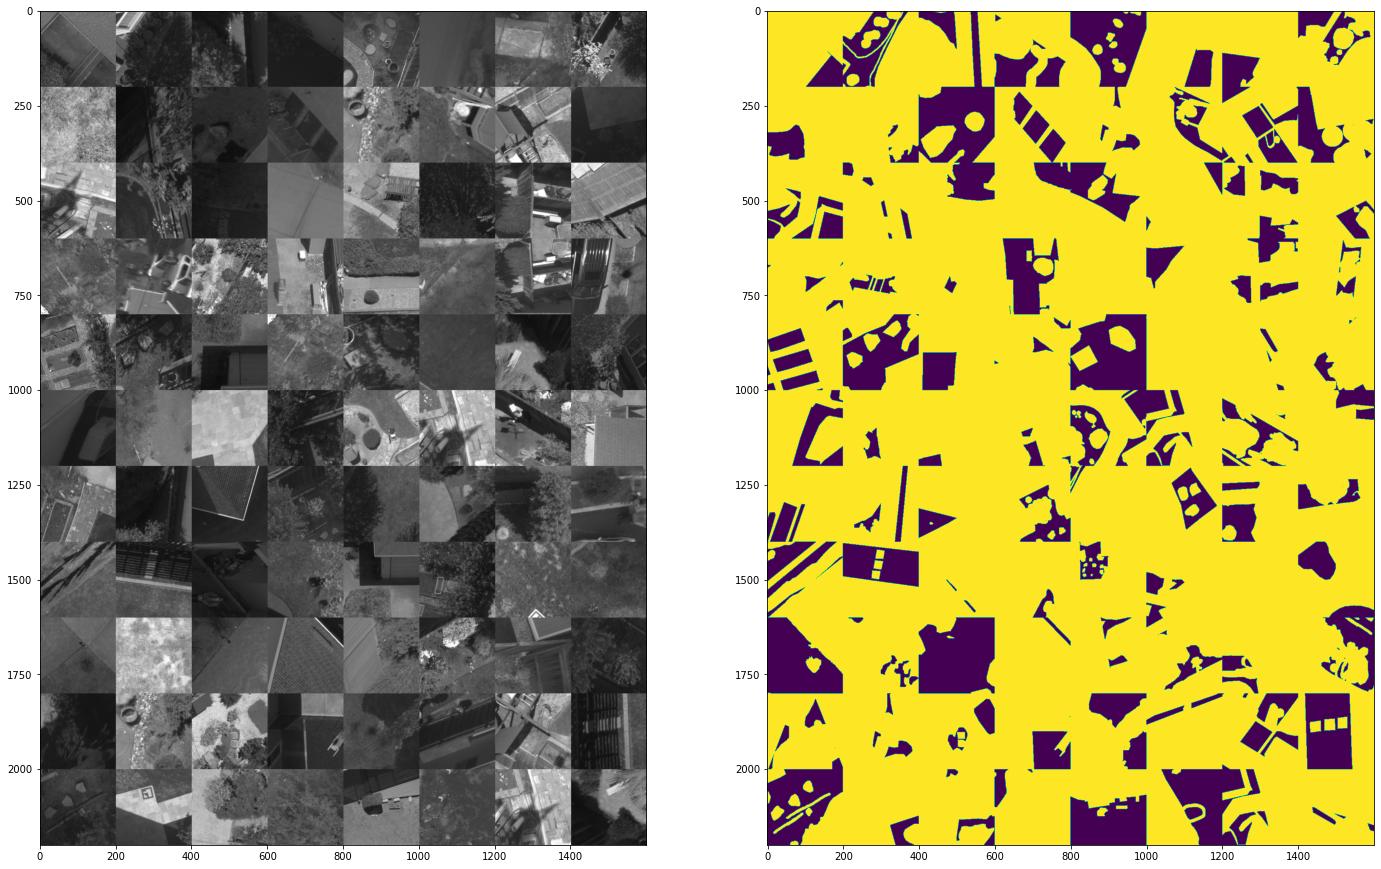

In [ ]:
plt.figure(figsize=(50,50))
# print(np.where(mask==1,1,0).sum())
plt.subplot(1,4,1)
plt.imshow(img_final.astype('uint8'))
plt.subplot(1,4,2)
plt.imshow(np.where(mask_final==13, 0,1))

In [ ]:
plt.figure(figsize=(150,150))
# print(np.where(mask==1,1,0).sum())
for ii in range(32):
    plt.subplot(8,4,ii+1)
    plt.imshow(wire_list[ii+32*0])

In [ ]:
'0b66b225b3cd460a932d7997666c69cc-1654619804300005511.png',  ## wire annotation is catatrophic


'1012f99c2c6149fd8d9673bdf54155d5-1616446840900003156.png', ## not wire, facade or 255
'1012f99c2c6149fd8d9673bdf54155d5-1616446846600003265.png', ## not wire, facade or 255
'1012f99c2c6149fd8d9673bdf54155d5-1616446850800003345.png', ## not wire, facade or 
'1012f99c2c6149fd8d9673bdf54155d5-1616446852900003400.png',  ## not wire, facade or 255

14c532a8627845af80a102597063b072-1621449119600012235.png ## no wire fence
14c532a8627845af80a102597063b072-1621449123600012307.png no wire fence
14c532a8627845af80a102597063b072-1621449129100012409.png no wire fence
14c532a8627845af80a102597063b072-1621449131800012457.png no wire fence

1d00b0a3a3f643f1ae268f87f3fd77f7-1614808728800010585.png fat wire

2926994c8b60434ea9b9d6886f359fc3-1619109308700004742.png #no wire
2926994c8b60434ea9b9d6886f359fc3-1619109318300004941.png # no wire
2926994c8b60434ea9b9d6886f359fc3-1619109322200005021.png #no wire

294f0a76a9214d71a00f27a4e14a7c45-1619548503300003403.png fat wire

2d000465163546eaa8287ab57c091a9d-1619718229600006697.png #no wire
2edb4632d8704502b777c84371521b39-1619462441500005943.png fat wire

3170e46abf8e4974bb0578b435743366-1617214532400014689.png no wire
344f520a2b0c407e9b22a516e03f49e9-1619647007200004576.png no wire
369eb1158f204016bb6d4509a4f72005-1644861999900002933.png no wire
3906767d75c44ba786670ea11765528f-1620680183500027396.png no a cable
3a915024fd15488cb4b8fe5762548a4b-1622586018400007185.png no wire


3d48491db6be4e5c807b29c49511d2e6-1612892341000001603.png good image for wire
3d48491db6be4e5c807b29c49511d2e6-1612892344500001679.png good image for wire

3d48491db6be4e5c807b29c49511d2e6-1612892348000001756.png no wire
412936ec1839402ca39745135e684364-1629667273300002772.png no wire
490999536d194a53bde8ddcff6994824-1617210399400005009.png no wire
490999536d194a53bde8ddcff6994824-1617210407200005147.png no wire
490999536d194a53bde8ddcff6994824-1617210411200005237.png no wire
5039e0e97ac748e0b7c398bd84117a74-1606950267000013875.png no wire
5039e0e97ac748e0b7c398bd84117a74-1606950288800014308.png no wire
54ae0a04fd24424ab9b73f1a804dcaee-1624551240600003033.png no wire
54ae0a04fd24424ab9b73f1a804dcaee-1624551240600003033.png no wire
54ae0a04fd24424ab9b73f1a804dcaee-1624551245200003110.png no wire
54ae0a04fd24424ab9b73f1a804dcaee-1624551248300003178.png no wire

5bcde0ccaef84b2692897574e4745b41-1622064925000003538.png fat wire

5bcf60c926e34fb3ad1c8fc935502261-1658359118700006983.png good image for wire
5ddfb70f423c40c4971219be81dee26f-1631916440500004233.png good image for wire
748f7ecdd8434553a7a8d341eda4419e-1621279542400003621.png good image for wire
748f7ecdd8434553a7a8d341eda4419e-1621279538000003535.png good image for wire
748f7ecdd8434553a7a8d341eda4419e-1621279548200003726.png  good image for wire

7c271774b5d943038775112dc2dd7af8-1623362738300006540.png no wire

7fe11e1aa96b42b7951f617db1bea549-1627595510300009807.png fat wire

87657a04c38c478fa99e4b86ff95ade1-1621278522800006959.png good image for wire

95be161966dc4ccf90ba1efbe1cb65a5-1619547412100010886.png fat wire
95be161966dc4ccf90ba1efbe1cb65a5-1619547422000011060.png fat wire

96fe8f9225c2416da801083de8b266ad-1618343217300009511.png fat wire

98fdd7d3fe50494583aa81092e5a08da-1631204780100002098.png good image for wire

98fdd7d3fe50494583aa81092e5a08da-1631204783000002151.png fat wire

9b5d64b124404976910296c14616b457-1654620515600009557.png  fat wire
9b5d64b124404976910296c14616b457-1654620516900009588.png fat wire
9fb3f1b0c18b47d9ab437c383e3112aa-1619547927400002788.png fat wire


b4556c0520b9486294ba24edb26be619-1630862699100003370.png  good image for wire
b79e3c6310574145b1ccc5dddb4502f1-1621280555500004594.png  good image for wire
b79e3c6310574145b1ccc5dddb4502f1-1621280556200004605.png  good image for wire

bf1925dff2f942b1a3d01462661be818-1632161439300006590.png no wire

d9f11224a93543dead4cbb1ea3a6ce84-1654619300000021325.png fat wire

ed4a3859216a48db8b6d04eed5aacdc5-1618343937200005558.png FAT WIRE
ed4a3859216a48db8b6d04eed5aacdc5-1618343942200005654.png FAT WIRE

f9fae46e09b14bd0b5d45ea2d7109d5e-1620145165500004668.png pilone need to be moved to 255
f9fae46e09b14bd0b5d45ea2d7109d5e-1620145171300004778.png pilone need to be moved to 255
